
# Amazon_alexa Dataset Classification Problem

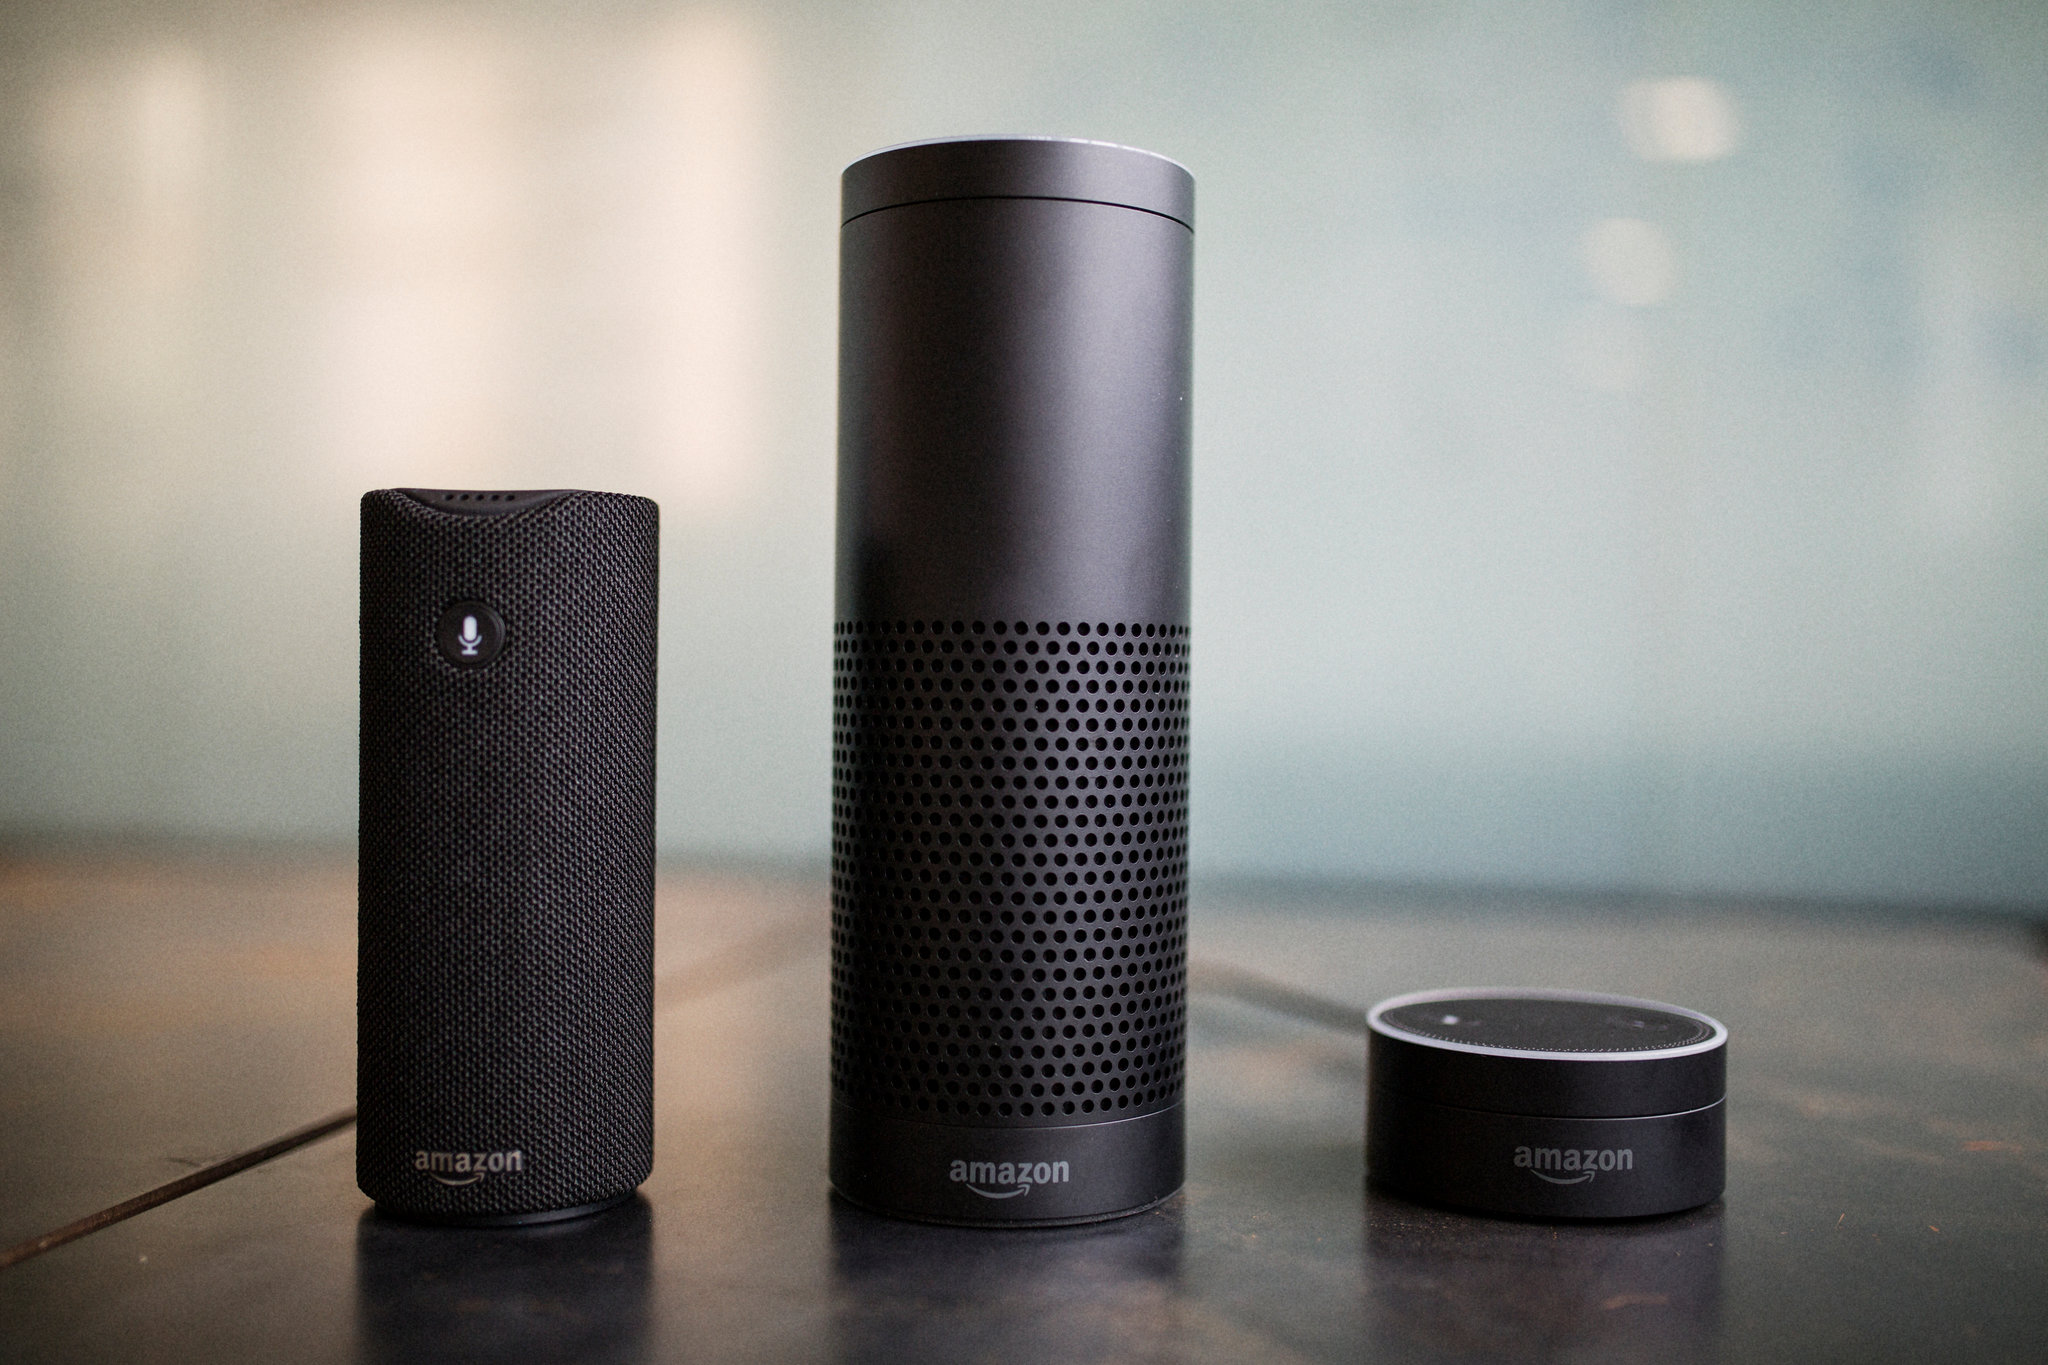

# Introduction: 

      In this project, we were building the ML models to practise so-called NLP for sentiment analysis of the popular service called Alexa which is virtual assistant technology by Amazon. We will train ML models to predict whether the review is positive or negative and try to find insights to find out which factors can possibly influence the overall user's experience of using the Amazon Alexa service.

# Objectives: 

    Our goals:

    1. To find insights in the reviews of the users
    
    2. To develop a Deep Learning model that predicts whether the feedback is a positive or negative one

#  Description:  

    1. Type of problem: classification.

    2. Variables: 1 Numerical, 3 Categorical:

        1. rating: the amount of stars in rating (1 - 5)

        2. date: the date of the review

        3. variation: types of Amazon Alexa models and configuration

        4. verified_reviews: the text review of the users

    3. Target: feedback (INT):

        1. feedback : 0 - negative; 1 - positive

    4. Steps we made

        1. Importing a dataset

        2. EDA

        3. Feature engineering
 
            1. Drop unnecessary variables

            2. Encoding variations:          

            3. Train/test split:

                > Train - 3 years

                > Test - 2 years 

            4. Encoding verified reviews:

                > CountVectorizer
                
            4. Balancing Dataset

            5. Training ML models

            6. fine-tuning hyperparameters

                > RandomizedSearchCV

            5. Model evaluation and results analysis

    5. ML Algorithms we used:

            1. Logistic regression

            2. RandomForest        

            3. SVC

            4. XGB
       
            5. GradientBoosting
       
            6. Naivebayes

            7. DecistionTree

            8. KNeighbors

    6. Evaluation metrics we used:

        1. F1 score

        2. Roc-auc

        3. Confusion Matrix

        4. Precision    

        5. Recall

        6. Accuracy

# STEP 0: Importing libraries

In [90]:
#libraries for Loading dataset and linear algebra
import pandas as pd
import numpy as np
import scipy.stats as stats
import math
from collections import Counter

#libraries for datetime variables
from datetime import date, time, datetime

#libraries for Visualising data
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from mlens.visualization import corrmat
from wordcloud import WordCloud
import altair as alt

#libraries for Spliting data set
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

#libraries for feature engineering
from sklearn.feature_extraction.text import CountVectorizer

#libraries for balancing the dataset
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

#libraries for Feature magnitude
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

#libraries for ML models: Classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

#libraries for Super Learner
from mlens.ensemble import SuperLearner

#libraries for Pipelines and Column Tranformers
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector

#libraries for hyperparametres tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#libraries for Matrixes for evaluating models
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#libraries for saving models
from pickle import dump, load

from jupyterthemes import jtplot
jtplot.style()

# STEP 1: Data analysis

## Importing Dataset


In [2]:
df_alexa = pd.read_csv('amazon_alexa.tsv', sep = '\t')
df_alexa

rating       date         variation  \
0          5  31-Jul-18  Charcoal Fabric    
1          5  31-Jul-18  Charcoal Fabric    
2          4  31-Jul-18    Walnut Finish    
3          5  31-Jul-18  Charcoal Fabric    
4          5  31-Jul-18  Charcoal Fabric    
...      ...        ...               ...   
3145       5  30-Jul-18        Black  Dot   
3146       5  30-Jul-18        Black  Dot   
3147       5  30-Jul-18        Black  Dot   
3148       5  30-Jul-18        White  Dot   
3149       4  29-Jul-18        Black  Dot   

                                       verified_reviews  feedback  
0                                         Love my Echo!         1  
1                                             Loved it!         1  
2     Sometimes while playing a game, you can answer...         1  
3     I have had a lot of fun with this thing. My 4 ...         1  
4                                                 Music         1  
...                                                 ...       ...  
3145  Perfect for kids, adults and everyone in betwe...         1  
3146  Listening to music, searching locations, check...         1  
3147  I do love these things, i have them running my...         1  
3148  Only complaint I have is that the sound qualit...         1  
3149                                               Good         1  

[3150 rows x 5 columns]

    We have 5 independent variables and 1 target

In [3]:
df_alexa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3150 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


## Checking the balance of the target

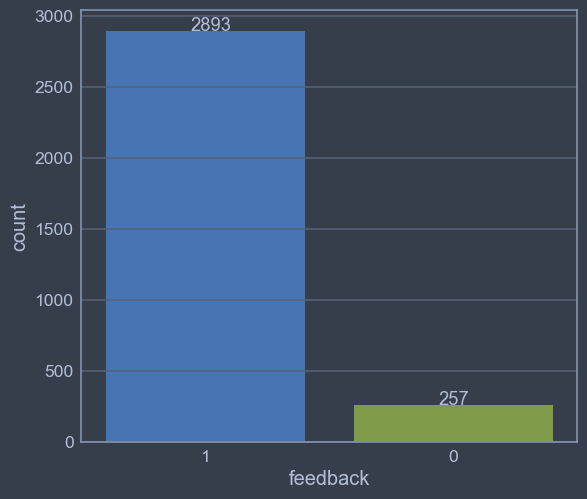

In [4]:
feedback = df_alexa['feedback'].value_counts(ascending = False)
ax = sns.countplot(x = df_alexa['feedback'], label = 'Count', order = feedback.index)
for p, label in zip(ax.patches, feedback.values):
    ax.annotate(np.around(label, 2), (p.get_x()+0.34, p.get_height()+0.3))

In [5]:
reviews = ['positive feedbacks', 'nagative feedbacks']
fig = px.pie(df_alexa, values = feedback, names = reviews, hole = 0.3)
fig.update_traces(textposition = 'inside', textinfo = 'percent+label')
fig.update_layout(template = 'plotly_dark')

    We can see that our dataset is not balanced at all and potentialy it can cause some problems in the future predictions. So that is why we will try to balance the dataset in the feature engineering step

## Creating new variable based on date of reviews

### Transfom variable to datetime format

In [6]:
df_alexa['date'] = pd.to_datetime(df_alexa['date'])
df_alexa.dtypes

rating                       int64
date                datetime64[ns]
variation                   object
verified_reviews            object
feedback                     int64
dtype: object

### Extracting year from date

In [7]:
df_alexa['year'] = df_alexa['date'].dt.year
df_alexa['year']

0       2018
1       2018
2       2018
3       2018
4       2018
        ... 
3145    2018
3146    2018
3147    2018
3148    2018
3149    2018
Name: year, Length: 3150, dtype: int64

### Extracting month from date

In [8]:
df_alexa['month'] = df_alexa['date'].dt.month
df_alexa['month']

0       7
1       7
2       7
3       7
4       7
       ..
3145    7
3146    7
3147    7
3148    7
3149    7
Name: month, Length: 3150, dtype: int64

### Extracting day from date

In [9]:
df_alexa['day'] = df_alexa['date'].dt.day
df_alexa['day']

0       31
1       31
2       31
3       31
4       31
        ..
3145    30
3146    30
3147    30
3148    30
3149    29
Name: day, Length: 3150, dtype: int64

In [10]:
df_alexa['weekday'] = df_alexa['date'].dt.dayofweek
df_alexa['weekday'] = df_alexa['weekday'].map({
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
})

In [11]:
df_alexa

rating       date         variation  \
0          5 2018-07-31  Charcoal Fabric    
1          5 2018-07-31  Charcoal Fabric    
2          4 2018-07-31    Walnut Finish    
3          5 2018-07-31  Charcoal Fabric    
4          5 2018-07-31  Charcoal Fabric    
...      ...        ...               ...   
3145       5 2018-07-30        Black  Dot   
3146       5 2018-07-30        Black  Dot   
3147       5 2018-07-30        Black  Dot   
3148       5 2018-07-30        White  Dot   
3149       4 2018-07-29        Black  Dot   

                                       verified_reviews  feedback  year  \
0                                         Love my Echo!         1  2018   
1                                             Loved it!         1  2018   
2     Sometimes while playing a game, you can answer...         1  2018   
3     I have had a lot of fun with this thing. My 4 ...         1  2018   
4                                                 Music         1  2018   
...                                                 ...       ...   ...   
3145  Perfect for kids, adults and everyone in betwe...         1  2018   
3146  Listening to music, searching locations, check...         1  2018   
3147  I do love these things, i have them running my...         1  2018   
3148  Only complaint I have is that the sound qualit...         1  2018   
3149                                               Good         1  2018   

      month  day  weekday  
0         7   31  Tuesday  
1         7   31  Tuesday  
2         7   31  Tuesday  
3         7   31  Tuesday  
4         7   31  Tuesday  
...     ...  ...      ...  
3145      7   30   Monday  
3146      7   30   Monday  
3147      7   30   Monday  
3148      7   30   Monday  
3149      7   29   Sunday  

[3150 rows x 9 columns]

## Exploring date of reviiews

### Exloring Year

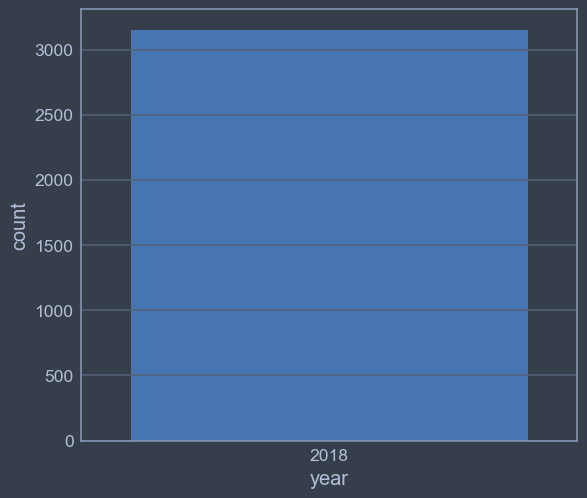

In [12]:
ax = sns.countplot(x = 'year', data = df_alexa)

    We can see that all the reviews were made in 2018 years. It's probably because the dataset itself includes only reviews made in 2018.

### Exploring months

[Text(0, 0, '82'), Text(0, 0, '155'), Text(0, 0, '2913')]

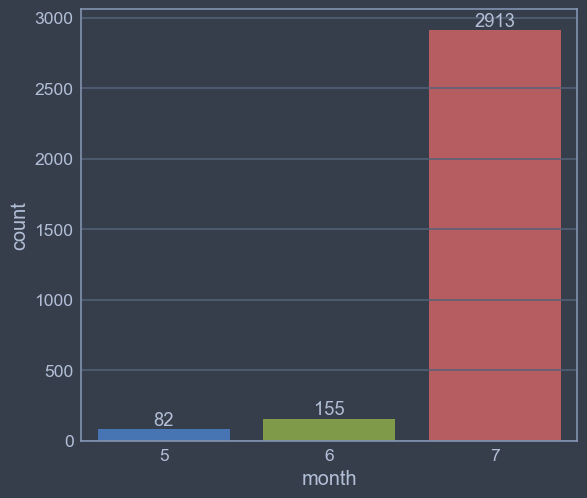

In [13]:
ax = sns.countplot(x = 'month', data = df_alexa)
ax.bar_label(container = ax.containers[0], labels = df_alexa['month'].value_counts(ascending = True), label_type = 'edge')

In [14]:
labels = ['5(May)', '6(June)', '7(July)']
fig = px.pie(df_alexa, values = df_alexa['month'].value_counts(ascending = True), names = labels, hole = 0.3)
fig.update_traces(textposition = 'inside', textinfo = 'percent+label')
fig.update_layout(template = 'plotly_dark')

    We can see that more than 90% of the reviews were made in the 7Th month(July)

### Exploring days and weekdays

[Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9'),
 Text(0, 0, '10'),
 Text(0, 0, '11'),
 Text(0, 0, '12'),
 Text(0, 0, '12'),
 Text(0, 0, '13'),
 Text(0, 0, '13'),
 Text(0, 0, '14'),
 Text(0, 0, '14'),
 Text(0, 0, '16'),
 Text(0, 0, '17'),
 Text(0, 0, '17'),
 Text(0, 0, '19'),
 Text(0, 0, '26'),
 Text(0, 0, '27'),
 Text(0, 0, '27'),
 Text(0, 0, '27'),
 Text(0, 0, '29'),
 Text(0, 0, '36'),
 Text(0, 0, '39'),
 Text(0, 0, '40'),
 Text(0, 0, '46'),
 Text(0, 0, '56'),
 Text(0, 0, '56'),
 Text(0, 0, '91'),
 Text(0, 0, '95'),
 Text(0, 0, '261'),
 Text(0, 0, '489'),
 Text(0, 0, '1613')]

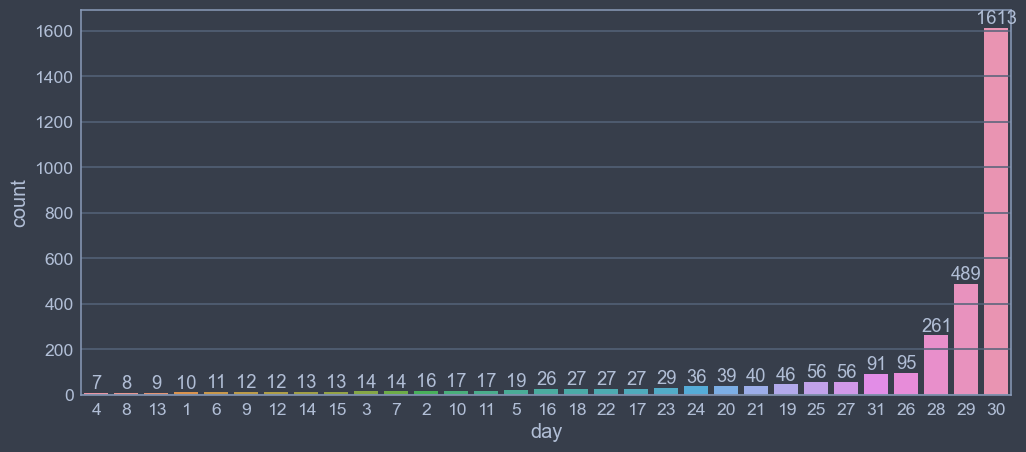

In [15]:
plt.figure(figsize = (12, 5))
ax = sns.countplot(x = 'day', data = df_alexa, order = df_alexa['day'].value_counts(ascending = True).index)
ax.bar_label(container = ax.containers[0], labels = df_alexa['day'].value_counts(ascending = True), label_type = 'edge')

In [16]:
labels = [str(var) for var in df_alexa['day'].value_counts(ascending = True).index]
fig = px.pie(df_alexa, values = df_alexa['day'].value_counts(ascending = True), names = labels, hole = 0.3)
fig.update_traces(textposition = 'inside', textinfo = 'percent+label')
fig.update_layout(template = 'plotly_dark')

    We can see that amlmost 75% of all reviews were made on 28, 29 and 30th day which is the end of the month, but the were a realy little amount of reviews on 31st days of each month. We assume that is just because not every month has 31st day in it

 ### Weekdays

[Text(0, 0, '105'),
 Text(0, 0, '113'),
 Text(0, 0, '167'),
 Text(0, 0, '189'),
 Text(0, 0, '314'),
 Text(0, 0, '565'),
 Text(0, 0, '1697')]

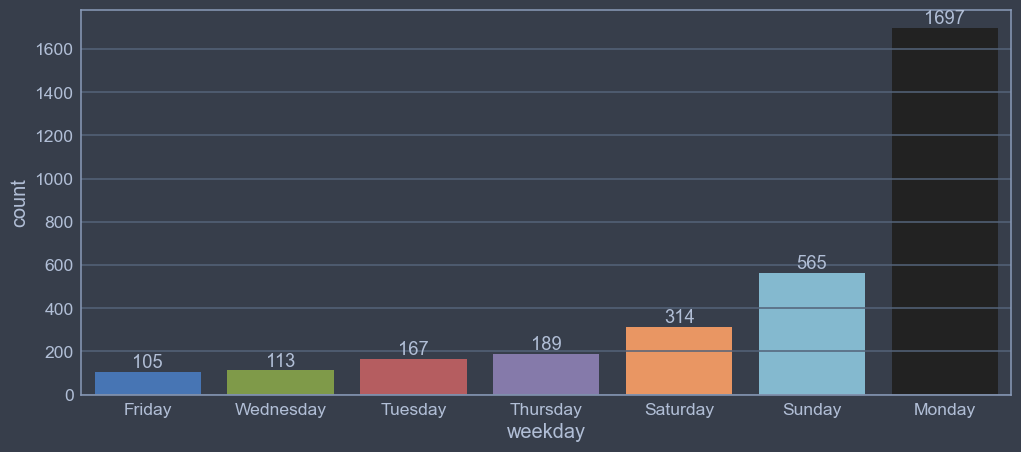

In [17]:
plt.figure(figsize = (12, 5))
ax = sns.countplot(x = 'weekday', data = df_alexa, order = df_alexa['weekday'].value_counts(ascending = True).index)
ax.bar_label(container = ax.containers[0], labels = df_alexa['weekday'].value_counts(ascending = True), label_type = 'edge')

In [18]:
labels = [str(var) for var in df_alexa['weekday'].value_counts(ascending = True).index]
fig = px.pie(df_alexa, values = df_alexa['weekday'].value_counts(ascending = True), names = labels, hole = 0.3)
fig.update_traces(textposition = 'inside', textinfo = 'percent+label')
fig.update_layout(template = 'plotly_dark')

    We can see that more than 50% of all reviews were made on Mondays, which is the beginning of the week, while almost 30% of all reviews were made on Saturdays and Sundays respectfully, which is the end of the week

    here are some insights we made based on date analysis
        1. All the reviews in our dataset were made in 2018
        2. The vast majority of all reviews were made on July
        3. The majority of all reviews were made by the end of the month(28, 29, 30)
        4. The majority of all reviews were made by the beggining (Monday) and the end(Saturday, Sunday) of the week

## Exploring  rating in the dataset

[Text(0, 0, '2286'),
 Text(0, 0, '455'),
 Text(0, 0, '161'),
 Text(0, 0, '152'),
 Text(0, 0, '96')]

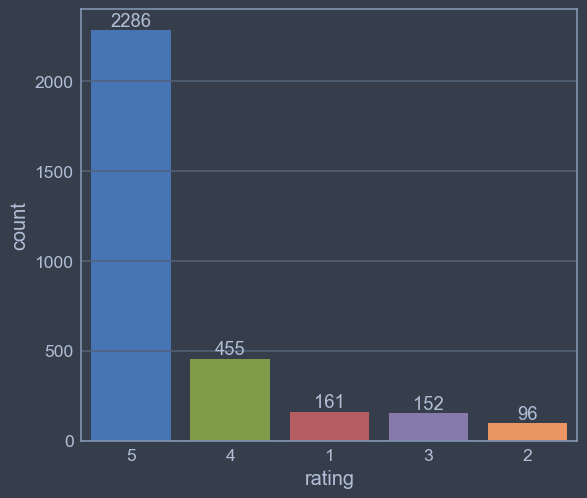

In [19]:
ratings = df_alexa['rating'].value_counts()
ax = sns.countplot(x = df_alexa['rating'], label = 'Count', order = ratings.index)
ax.bar_label(container = ax.containers[0], labels = ratings.values, label_type = 'edge')

In [20]:
labels = ['rating_5', 'rating_4', 'rating_1', 'rating_3', 'rating_2']
fig = px.pie(df_alexa, values = ratings, names = labels, hole = 0.3)
fig.update_traces(textposition = 'inside', textinfo = 'percent+label')
fig.update_layout(template = 'plotly_dark')

    We can see that more than 70% of the dataset consist of 5 star ratings which means that majority of reviews were on the positive side including 5 and 4 star ratings and the little amount of rewiews were probably on the negative side including 3, 2 and 1 star reviews

## Exploring variations

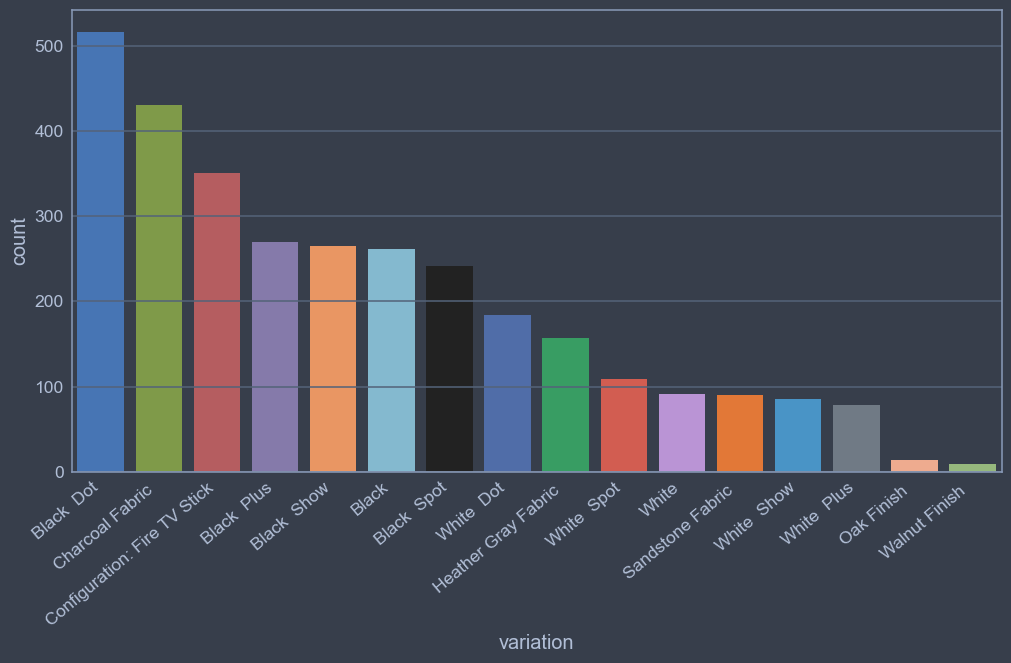

In [21]:
variations = df_alexa['variation'].value_counts()
plt.figure(figsize=(12,6))
ax = sns.countplot(x = df_alexa['variation'], label = 'Count', order = variations.index)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 40, ha = "right")
plt.show()

In [22]:
df_variations = pd.DataFrame({
    'variations' : variations.index,
    'Count': variations
})

df_variations.reset_index(inplace = True)
df_variations.drop('index', axis = 1, inplace = True)
df_variations

variations  Count
0                     Black  Dot    516
1               Charcoal Fabric     430
2   Configuration: Fire TV Stick    350
3                    Black  Plus    270
4                    Black  Show    265
5                          Black    261
6                    Black  Spot    241
7                     White  Dot    184
8           Heather Gray Fabric     157
9                    White  Spot    109
10                         White     91
11             Sandstone Fabric      90
12                   White  Show     85
13                   White  Plus     78
14                   Oak Finish      14
15                Walnut Finish       9

In [23]:
labels = [str(var) for var in df_alexa['variation'].value_counts().index]
fig = px.pie(df_alexa, values = variations, names = labels, hole = 0.3)
fig.update_traces(textposition = 'inside', textinfo = 'percent+label')
fig.update_layout(title = 'Percentage of Each variation', template = 'plotly_dark')

    We can see that Black Dot is the most popular variation among all others, taking about 16% of all orders, while the Oak Finish and Walnut Finish are the least popular ones, taking less than 0.5% respectively

## Exploring relation of variations and ratings

In [24]:
df_variation_rating = pd.DataFrame(data = df_alexa.groupby(['variation'])['rating'].value_counts())
df_variation_rating = df_variation_rating['rating'].astype(int)
df_variation_rating = df_variation_rating.unstack()
df_variation_rating = df_variation_rating.fillna('0')
df_variation_rating.reset_index(inplace = True)
df_variation_rating.columns = ['variation', 'rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5']
df_variation_rating.sort_values(by = 'rating_5', ascending = False)

variation rating_1 rating_2 rating_3  rating_4  \
1                     Black  Dot     22.0     14.0     34.0      84.0   
5               Charcoal Fabric       4.0      8.0     10.0      56.0   
6   Configuration: Fire TV Stick     13.0     15.0      6.0      34.0   
3                    Black  Show     10.0      8.0     14.0      43.0   
2                    Black  Plus     17.0     11.0     14.0      41.0   
0                          Black     30.0      5.0     15.0      35.0   
4                    Black  Spot     18.0     14.0     11.0      30.0   
12                    White  Dot     10.0      2.0     12.0      36.0   
7           Heather Gray Fabric         0      2.0     10.0      22.0   
15                   White  Spot      9.0      3.0      6.0      18.0   
11                         White     13.0      4.0      1.0      12.0   
14                   White  Show      8.0      3.0      3.0      14.0   
9              Sandstone Fabric       2.0      4.0     10.0      18.0   
13                   White  Plus      5.0      3.0      6.0       9.0   
8                    Oak Finish         0        0        0       2.0   
10                Walnut Finish         0        0        0       1.0   

    rating_5  
1      362.0  
5      352.0  
6      282.0  
3      190.0  
2      187.0  
0      176.0  
4      168.0  
12     124.0  
7      123.0  
15      73.0  
11      61.0  
14      57.0  
9       56.0  
13      55.0  
8       12.0  
10       8.0

In [25]:
rating_1 = go.Bar(x = df_variation_rating['variation'], y = df_variation_rating.rating_1, name = 'raing_1')
rating_2 = go.Bar(x = df_variation_rating['variation'], y = df_variation_rating.rating_2, name = 'raing_2')
rating_3 = go.Bar(x = df_variation_rating['variation'], y = df_variation_rating.rating_3, name = 'raing_3')
rating_4 = go.Bar(x = df_variation_rating['variation'], y = df_variation_rating.rating_4, name = 'raing_4')
rating_5 = go.Bar(x = df_variation_rating['variation'], y = df_variation_rating.rating_5, name = 'raing_5')
arker = dict(color = 'rgba(255, 128, 255, 0.8)')
data = [rating_1, rating_2, rating_3, rating_4, rating_5]
layout = {'title': 'Ratings in Variatinos',
          'barmode': 'relative',
          'xaxis': {'title': 'Variations'},
          'yaxis': {'title': 'Ratings'},
          'template': 'plotly_dark'}
fig = go.Figure(data, layout)
fig.update_traces()
fig.show()

    We can see that the Black Dot and Charcoal variation are recieving highest ratings comparing to others, while Black Dot variation also has the biggest amount of low ratings (1, 2, 3 stars)

## Exploring relation of variations and feedbacks

In [26]:
df_variation_target = pd.DataFrame(data = df_alexa.groupby('variation')['feedback'].value_counts())
df_variation_target = df_variation_target.unstack()
df_variation_target.reset_index(inplace = True)
df_variation_target.fillna(0, inplace = True)
df_variation_target.sort_values(by = [('feedback', 1)], ascending = False)

variation feedback       
feedback                                      0      1
1                           Black  Dot     36.0  480.0
5                     Charcoal Fabric      12.0  418.0
6         Configuration: Fire TV Stick     28.0  322.0
3                          Black  Show     18.0  247.0
2                          Black  Plus     28.0  242.0
0                                Black     35.0  226.0
4                          Black  Spot     32.0  209.0
12                          White  Dot     12.0  172.0
7                 Heather Gray Fabric       2.0  155.0
15                         White  Spot     12.0   97.0
9                    Sandstone Fabric       6.0   84.0
11                               White     17.0   74.0
14                         White  Show     11.0   74.0
13                         White  Plus      8.0   70.0
8                          Oak Finish       0.0   14.0
10                      Walnut Finish       0.0    9.0

In [27]:
negative = go.Bar(x = df_variation_target['variation'], y = df_variation_target['feedback'][0], name = 'negative feedback')
positie = go.Bar(x = df_variation_target['variation'], y = df_variation_target['feedback'][1], name = 'posirive feedback')
data = [positie, negative]
layout = {
    'title': 'feedbacks in variations',
    'template': 'plotly_dark'
}
fig = go.Figure(data, layout)
fig.show()

    It can be seen that Black Dot, Charcoal Fabric and Configuration: Fire TV Stick are three variations with the biggest amount of positive feedbacks, while Black Dot, Black and Black Spot are getting more negative feedbacks comparing to others

## Exploring relation of ratings and feedbacks

In [28]:
df_ratings_feedback = pd.DataFrame(data = df_alexa.groupby(['feedback'])['rating'].value_counts())
df_ratings_feedback

rating
feedback rating        
0        1          161
         2           96
1        5         2286
         4          455
         3          152

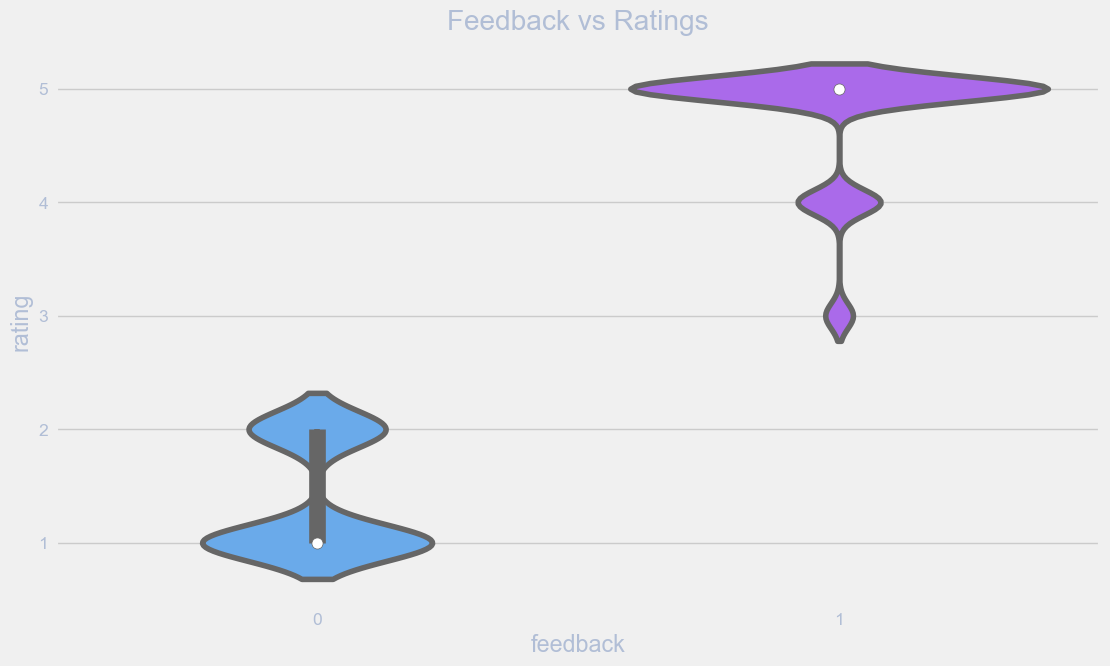

In [29]:
plt.rcParams['figure.figsize'] = (12, 7)
plt.style.use('fivethirtyeight')

sns.violinplot(x = df_alexa['feedback'], y = df_alexa['rating'], palette = 'cool',)
plt.title("Feedback vs Ratings")
plt.show()

    Here we can see that if the product has rating 1 or 2 it will be the negative feedback, on the other hand, if the rating is equal or more than 3 stars, it will probably be the positive feedback

## Finding Null values

In [30]:
vars_with_Nan = [var for var in df_alexa.columns if df_alexa[var].isnull().sum() > 0]
print('the amount of null values: ', len(vars_with_Nan))

the amount of null values:  0


    There are no Null values in the Dataset

## Correlation

In [31]:
corr_table = df_alexa.corr()
corr_table

rating  feedback  year     month       day
rating    1.000000  0.861968   NaN  0.057939  0.067992
feedback  0.861968  1.000000   NaN  0.061239  0.070432
year           NaN       NaN   NaN       NaN       NaN
month     0.057939  0.061239   NaN  1.000000  0.312654
day       0.067992  0.070432   NaN  0.312654  1.000000

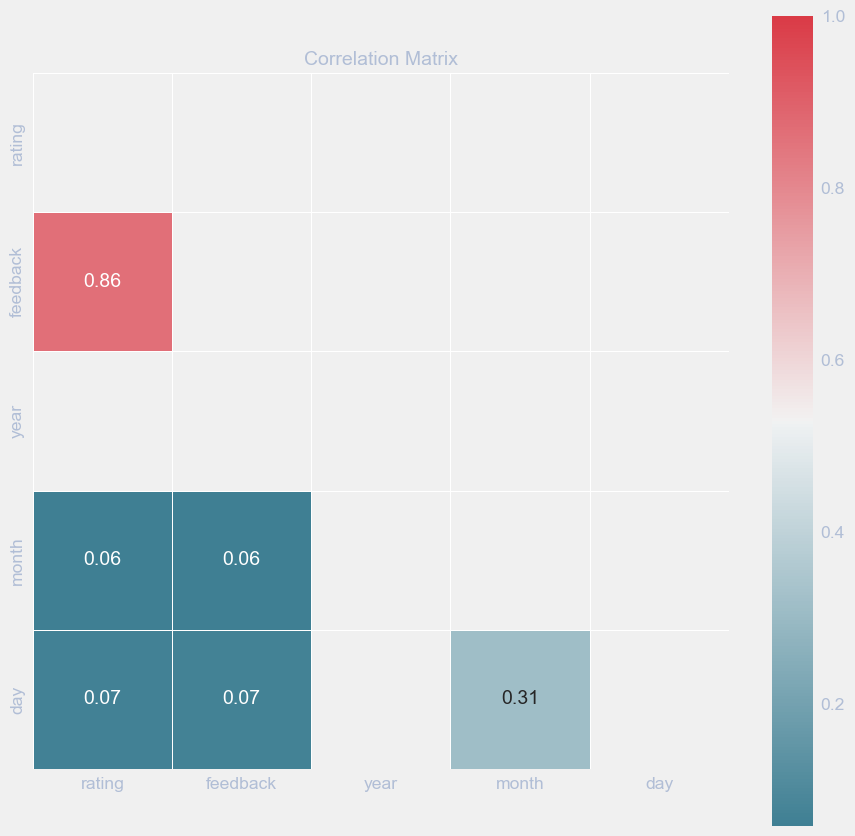

In [32]:
corrmat(corr_table, figsize = (10, 10), inflate = False)
plt.show()

In [33]:
positive = df_alexa[df_alexa['feedback'] == 1]
negative = df_alexa[df_alexa['feedback'] == 0]

## Most common words in positive reviews

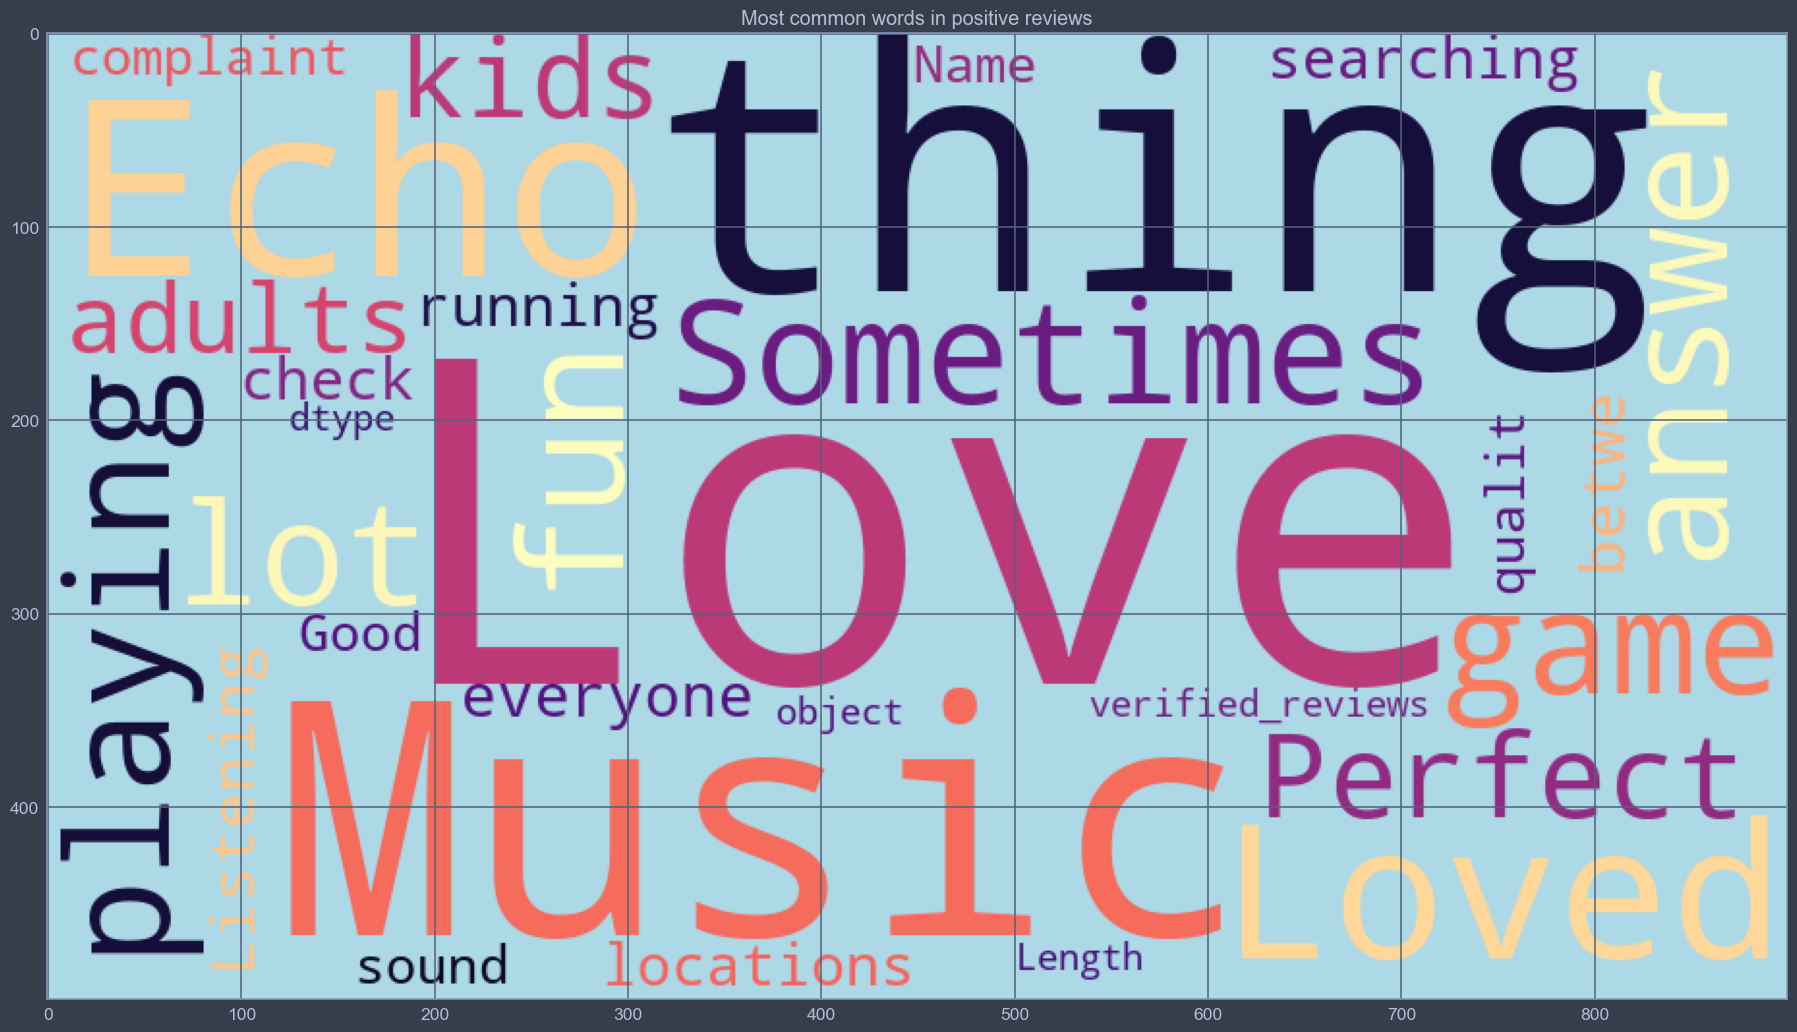

In [34]:
from jupyterthemes import jtplot
jtplot.style()

plt.figure(figsize = (20, 200))
wc = WordCloud(
    max_words = 3000,
    width = 900, 
    height = 500,
    background_color = 'lightblue',
    colormap = 'magma').generate(str(positive['verified_reviews']))
plt.title('Most common words in positive reviews')

plt.imshow(wc)
plt.show()

here we can see that the bigger the size of the word, the more it is being used in the positive reviews. We can see that the words like: Love, Thing, Music and etc. are one of the frequently used words in the positive feedbacks

## Most common words in negarive reviews

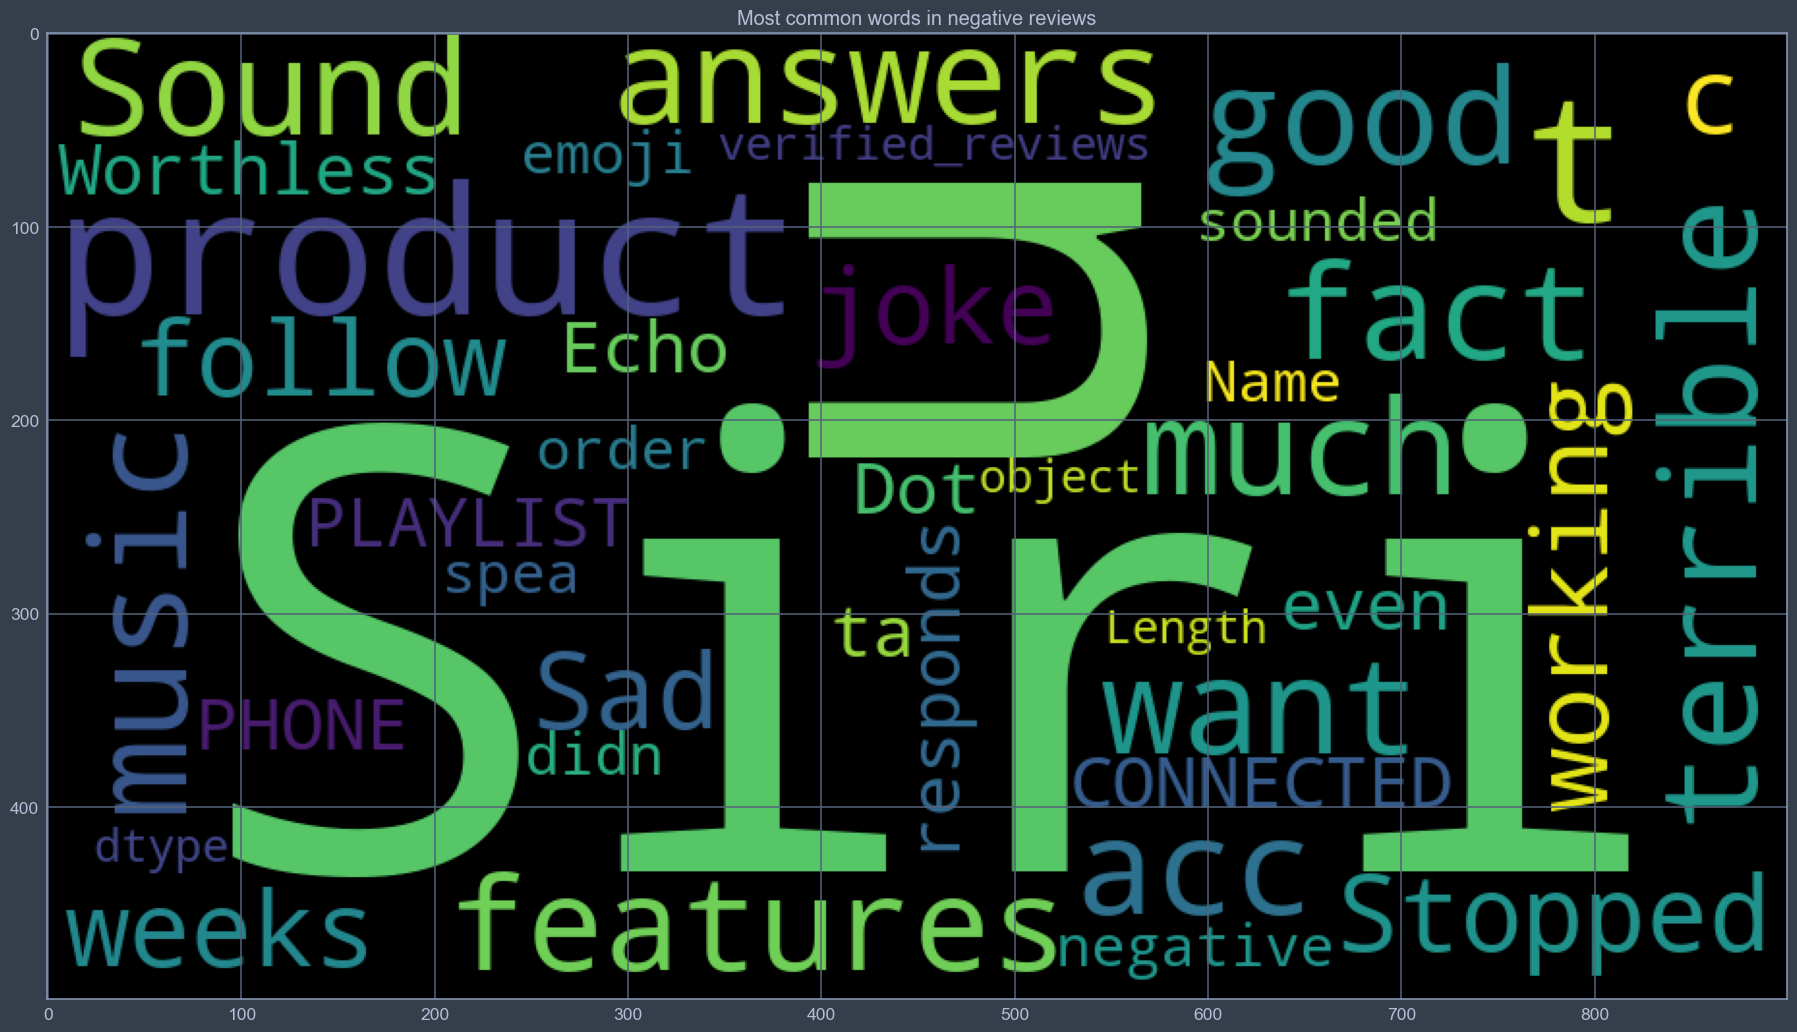

In [35]:
plt.figure(figsize = (20, 200))
wc = WordCloud(
    max_words = 3000,
    width = 900, 
    height = 500).generate(str(negative['verified_reviews']))
plt.title('Most common words in negative reviews')

plt.imshow(wc)
plt.show()

    here we can see that the bigger the size of the word, the more it is being used in the negative reviews. We can see that the words like: Siri, product, terrible and etc. are  one of the frequently used words in the negative feedbacks

# STEP 2: Feature engineering

## droping unnecessary variables

In [36]:
df_alexa.drop(['rating', 'date', 'year', 'month', 'day', 'weekday'], axis = 1, inplace = True)

In [37]:
df_alexa

variation                                   verified_reviews  \
0     Charcoal Fabric                                       Love my Echo!   
1     Charcoal Fabric                                           Loved it!   
2       Walnut Finish   Sometimes while playing a game, you can answer...   
3     Charcoal Fabric   I have had a lot of fun with this thing. My 4 ...   
4     Charcoal Fabric                                               Music   
...                ...                                                ...   
3145        Black  Dot  Perfect for kids, adults and everyone in betwe...   
3146        Black  Dot  Listening to music, searching locations, check...   
3147        Black  Dot  I do love these things, i have them running my...   
3148        White  Dot  Only complaint I have is that the sound qualit...   
3149        Black  Dot                                               Good   

      feedback  
0            1  
1            1  
2            1  
3            1  
4            1  
...        ...  
3145         1  
3146         1  
3147         1  
3148         1  
3149         1  

[3150 rows x 3 columns]

## Encoding variations

In [38]:
variations_dummies = pd.get_dummies(df_alexa['variation'], drop_first = True)

variations_dummies

Black  Dot  Black  Plus  Black  Show  Black  Spot  Charcoal Fabric   \
0              0            0            0            0                 1   
1              0            0            0            0                 1   
2              0            0            0            0                 0   
3              0            0            0            0                 1   
4              0            0            0            0                 1   
...          ...          ...          ...          ...               ...   
3145           1            0            0            0                 0   
3146           1            0            0            0                 0   
3147           1            0            0            0                 0   
3148           0            0            0            0                 0   
3149           1            0            0            0                 0   

      Configuration: Fire TV Stick  Heather Gray Fabric   Oak Finish   \
0                                0                     0            0   
1                                0                     0            0   
2                                0                     0            0   
3                                0                     0            0   
4                                0                     0            0   
...                            ...                   ...          ...   
3145                             0                     0            0   
3146                             0                     0            0   
3147                             0                     0            0   
3148                             0                     0            0   
3149                             0                     0            0   

      Sandstone Fabric   Walnut Finish   White  White  Dot  White  Plus  \
0                     0               0      0           0            0   
1                     0               0      0           0            0   
2                     0               1      0           0            0   
3                     0               0      0           0            0   
4                     0               0      0           0            0   
...                 ...             ...    ...         ...          ...   
3145                  0               0      0           0            0   
3146                  0               0      0           0            0   
3147                  0               0      0           0            0   
3148                  0               0      0           1            0   
3149                  0               0      0           0            0   

      White  Show  White  Spot  
0               0            0  
1               0            0  
2               0            0  
3               0            0  
4               0            0  
...           ...          ...  
3145            0            0  
3146            0            0  
3147            0            0  
3148            0            0  
3149            0            0  

[3150 rows x 15 columns]

In [39]:
df_alexa.drop(labels = ['variation'], axis = 1, inplace = True)

In [40]:
df_alexa = pd.concat([df_alexa, variations_dummies], axis = 1)
df_alexa

verified_reviews  feedback  Black  Dot  \
0                                         Love my Echo!         1           0   
1                                             Loved it!         1           0   
2     Sometimes while playing a game, you can answer...         1           0   
3     I have had a lot of fun with this thing. My 4 ...         1           0   
4                                                 Music         1           0   
...                                                 ...       ...         ...   
3145  Perfect for kids, adults and everyone in betwe...         1           1   
3146  Listening to music, searching locations, check...         1           1   
3147  I do love these things, i have them running my...         1           1   
3148  Only complaint I have is that the sound qualit...         1           0   
3149                                               Good         1           1   

      Black  Plus  Black  Show  Black  Spot  Charcoal Fabric   \
0               0            0            0                 1   
1               0            0            0                 1   
2               0            0            0                 0   
3               0            0            0                 1   
4               0            0            0                 1   
...           ...          ...          ...               ...   
3145            0            0            0                 0   
3146            0            0            0                 0   
3147            0            0            0                 0   
3148            0            0            0                 0   
3149            0            0            0                 0   

      Configuration: Fire TV Stick  Heather Gray Fabric   Oak Finish   \
0                                0                     0            0   
1                                0                     0            0   
2                                0                     0            0   
3                                0                     0            0   
4                                0                     0            0   
...                            ...                   ...          ...   
3145                             0                     0            0   
3146                             0                     0            0   
3147                             0                     0            0   
3148                             0                     0            0   
3149                             0                     0            0   

      Sandstone Fabric   Walnut Finish   White  White  Dot  White  Plus  \
0                     0               0      0           0            0   
1                     0               0      0           0            0   
2                     0               1      0           0            0   
3                     0               0      0           0            0   
4                     0               0      0           0            0   
...                 ...             ...    ...         ...          ...   
3145                  0               0      0           0            0   
3146                  0               0      0           0            0   
3147                  0               0      0           0            0   
3148                  0               0      0           1            0   
3149                  0               0      0           0            0   

      White  Show  White  Spot  
0               0            0  
1               0            0  
2               0            0  
3               0            0  
4               0            0  
...           ...          ...  
3145            0            0  
3146            0            0  
3147            0            0  
3148            0            0  
3149            0            0  

[3150 rows x 17 columns]

## Deviding to train and test datasets

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    df_alexa.drop(['feedback'], axis = 1),
    df_alexa['feedback'],
    test_size = 0.3,
    random_state = 0
)

X_train.shape, X_test.shape

((2205, 16), (945, 16))

In [42]:
Counter(y_train), Counter(y_test)

(Counter({1: 2023, 0: 182}), Counter({1: 870, 0: 75}))

## Encoding varified reviews using CountVectorizer

In [43]:
vectorizer = CountVectorizer(stop_words = 'english')
vectorizer.fit(X_train['verified_reviews'])
vectorizer.get_feature_names_out()

array(['00', '000', '07', ..., 'zero', 'zigbee', 'zzzz'], dtype=object)

In [44]:
#train set
reviews_train = vectorizer.transform(X_train['verified_reviews'])
reviews_train = pd.DataFrame(reviews_train.toarray())
reviews_train.index = X_train.index

#test set
reviews_test = vectorizer.transform(X_test['verified_reviews'])
reviews_test = pd.DataFrame(reviews_test.toarray())
reviews_test.index = X_test.index

In [45]:
reviews_train

0     1     2     3     4     5     6     7     8     9     ...  3277  \
132      0     0     0     0     0     0     0     0     0     0  ...     0   
2063     0     0     0     0     0     0     0     0     0     0  ...     0   
1709     0     0     0     0     0     0     0     0     0     0  ...     0   
526      0     0     0     0     0     0     0     0     0     0  ...     0   
933      0     0     0     0     0     0     0     0     0     0  ...     0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
763      0     0     0     0     0     0     0     0     0     0  ...     0   
835      0     0     0     0     0     0     0     0     0     0  ...     0   
1653     0     0     0     0     0     0     0     0     0     0  ...     0   
2607     0     0     0     0     0     0     0     0     0     0  ...     0   
2732     0     0     0     0     0     0     0     0     0     0  ...     0   

      3278  3279  3280  3281  3282  3283  3284  3285  3286  
132      0     0     0     0     0     0     0     0     0  
2063     0     0     0     0     0     0     0     0     0  
1709     0     0     0     0     0     0     0     0     0  
526      0     0     0     0     0     0     0     0     0  
933      0     0     0     0     0     0     0     0     0  
...    ...   ...   ...   ...   ...   ...   ...   ...   ...  
763      0     0     0     0     0     0     0     0     0  
835      0     0     0     0     0     0     0     0     0  
1653     0     0     0     0     0     0     0     0     0  
2607     0     0     0     0     0     0     0     0     0  
2732     0     0     0     0     0     0     0     0     0  

[2205 rows x 3287 columns]

In [46]:
X_train.drop(['verified_reviews'], axis = 1, inplace = True)
X_test.drop(['verified_reviews'], axis = 1, inplace = True)

In [47]:
X_train_tf = pd.concat([X_train, reviews_train], axis = 1)
X_test_tf = pd.concat([X_test, reviews_test], axis = 1)

In [48]:
X_train_tf

Black  Dot  Black  Plus  Black  Show  Black  Spot  Charcoal Fabric   \
132            0            0            0            0                 1   
2063           0            1            0            0                 0   
1709           0            0            1            0                 0   
526            0            0            0            0                 0   
933            0            0            0            0                 0   
...          ...          ...          ...          ...               ...   
763            0            0            0            0                 1   
835            0            0            0            0                 1   
1653           0            0            1            0                 0   
2607           1            0            0            0                 0   
2732           1            0            0            0                 0   

      Configuration: Fire TV Stick  Heather Gray Fabric   Oak Finish   \
132                              0                     0            0   
2063                             0                     0            0   
1709                             0                     0            0   
526                              0                     0            0   
933                              0                     1            0   
...                            ...                   ...          ...   
763                              0                     0            0   
835                              0                     0            0   
1653                             0                     0            0   
2607                             0                     0            0   
2732                             0                     0            0   

      Sandstone Fabric   Walnut Finish   ...  3277  3278  3279  3280  3281  \
132                   0               0  ...     0     0     0     0     0   
2063                  0               0  ...     0     0     0     0     0   
1709                  0               0  ...     0     0     0     0     0   
526                   0               0  ...     0     0     0     0     0   
933                   0               0  ...     0     0     0     0     0   
...                 ...             ...  ...   ...   ...   ...   ...   ...   
763                   0               0  ...     0     0     0     0     0   
835                   0               0  ...     0     0     0     0     0   
1653                  0               0  ...     0     0     0     0     0   
2607                  0               0  ...     0     0     0     0     0   
2732                  0               0  ...     0     0     0     0     0   

      3282  3283  3284  3285  3286  
132      0     0     0     0     0  
2063     0     0     0     0     0  
1709     0     0     0     0     0  
526      0     0     0     0     0  
933      0     0     0     0     0  
...    ...   ...   ...   ...   ...  
763      0     0     0     0     0  
835      0     0     0     0     0  
1653     0     0     0     0     0  
2607     0     0     0     0     0  
2732     0     0     0     0     0  

[2205 rows x 3302 columns]

In [49]:
X_test_tf

Black  Dot  Black  Plus  Black  Show  Black  Spot  Charcoal Fabric   \
422            0            0            0            0                 0   
1581           0            0            1            0                 0   
1185           0            0            0            1                 0   
683            0            0            0            0                 0   
305            0            0            0            0                 0   
...          ...          ...          ...          ...               ...   
1203           0            0            0            0                 0   
1184           0            0            0            1                 0   
817            0            0            0            0                 1   
896            0            0            0            0                 0   
303            0            0            0            0                 0   

      Configuration: Fire TV Stick  Heather Gray Fabric   Oak Finish   \
422                              0                     0            0   
1581                             0                     0            0   
1185                             0                     0            0   
683                              0                     0            0   
305                              0                     0            0   
...                            ...                   ...          ...   
1203                             0                     0            0   
1184                             0                     0            0   
817                              0                     0            0   
896                              0                     0            0   
303                              0                     1            0   

      Sandstone Fabric   Walnut Finish   ...  3277  3278  3279  3280  3281  \
422                   0               0  ...     0     0     0     0     0   
1581                  0               0  ...     0     0     0     0     0   
1185                  0               0  ...     0     0     0     0     0   
683                   0               0  ...     0     0     0     0     0   
305                   1               0  ...     0     0     0     0     0   
...                 ...             ...  ...   ...   ...   ...   ...   ...   
1203                  0               0  ...     0     0     0     0     0   
1184                  0               0  ...     0     0     0     0     0   
817                   0               0  ...     0     0     0     0     0   
896                   1               0  ...     0     0     0     0     0   
303                   0               0  ...     0     0     0     0     0   

      3282  3283  3284  3285  3286  
422      0     0     0     0     0  
1581     0     0     0     0     0  
1185     0     0     0     0     0  
683      0     0     0     0     0  
305      0     0     0     0     0  
...    ...   ...   ...   ...   ...  
1203     0     0     0     0     0  
1184     0     0     0     0     0  
817      0     0     0     0     0  
896      0     0     0     0     0  
303      0     0     0     0     0  

[945 rows x 3302 columns]

In [50]:
X_train_tf.columns = X_train_tf.columns.astype(str)
X_test_tf.columns = X_train_tf.columns.astype(str)

## Balancing Dataset

In [51]:
ROS = RandomOverSampler()
RUS = RandomUnderSampler()
Smote = SMOTE(k_neighbors = 5)

In [52]:
X_train_ros, y_train_ros = ROS.fit_resample(X_train_tf, y_train)
X_train_rus, y_train_rus = RUS.fit_resample(X_train_tf, y_train)
X_train_smore, y_train_smote = Smote.fit_resample(X_train_tf, y_train)

In [53]:
print(Counter(y_train_ros))
print(Counter(y_train_rus))
print(Counter(y_train_smote))

Counter({1: 2023, 0: 2023})
Counter({0: 182, 1: 182})
Counter({1: 2023, 0: 2023})


We chose 3 ways of balancing dataset to then compare them all and choose the best one

# STEP 3: Assigning all the models we will use

In [54]:
RandomForest = RandomForestClassifier()
GradientBoost = GradientBoostingClassifier()
DecistionTree = DecisionTreeClassifier()
KNeighbors = KNeighborsClassifier()
Logistic = LogisticRegression()
Svc = SVC(probability = True)
XGB = XGBClassifier()
Naivebayes = GaussianNB()

models = {
    'RandomForest': RandomForest,
    'GradientBoost': GradientBoost,
    'DecistionTree': DecistionTree,
    'KNeighbors': KNeighbors,
    'Logistic': Logistic,
    'Svc': Svc,
    'XGB': XGB,
    'Naivebayes': Naivebayes
}

We chose 8 popular ML models to start with to then compare them all and choose only several ones

# STEP 4: Fitting all the model

## Function for fitting and testing the models

In [55]:
def fit_test(X_tr_transformed, X_tr_balanced, X_te_transformed, y_tr, y_tr_balanced, y_te, model_list):
    accuracy_train_l = []
    accuracy_test_l = []
    f1_train_l = []
    f1_test_l = []
    for model in model_list:
        model.fit(X_tr_balanced, y_tr_balanced)
        preds_train = model.predict(X_tr_transformed)
        preds_test = model.predict(X_te_transformed)
        
        accuracy_train = accuracy_score(y_tr, preds_train)
        accuracy_test = accuracy_score(y_te, preds_test)
        f1_train = f1_score(y_tr, preds_train)
        f1_test = f1_score(y_te, preds_test)
        
        accuracy_train_l.append(accuracy_train)
        accuracy_test_l.append(accuracy_test)
        f1_train_l.append(f1_train)
        f1_test_l.append(f1_test)
        print(model, '\n accuracy(train): {} \n accuracy(test): {} \n'.format(accuracy_train, accuracy_test))
    return accuracy_train_l, accuracy_test_l, f1_train_l, f1_test_l

## RandomOverSampler

In [56]:
accuracy_train_ROS, accuracy_test_ROS, f1_train_ROS, f1_test_ROS = fit_test(X_train_tf,
                                                                            X_train_ros,
                                                                            X_test_tf,
                                                                            y_train,
                                                                            y_train_ros,
                                                                            y_test, 
                                                                            models.values())

RandomForestClassifier() 
 accuracy(train): 0.9913832199546485 
 accuracy(test): 0.8984126984126984 

GradientBoostingClassifier() 
 accuracy(train): 0.8580498866213152 
 accuracy(test): 0.816931216931217 

DecisionTreeClassifier() 
 accuracy(train): 0.9913832199546485 
 accuracy(test): 0.8698412698412699 

KNeighborsClassifier() 
 accuracy(train): 0.8467120181405896 
 accuracy(test): 0.7566137566137566 

LogisticRegression() 
 accuracy(train): 0.9859410430839002 
 accuracy(test): 0.9185185185185185 

SVC(probability=True) 
 accuracy(train): 0.9863945578231292 
 accuracy(test): 0.9238095238095239 

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_b

## RandomUnderSampler

In [57]:
accuracy_train_RUS, accuracy_test_RUS, f1_train_RUS, f1_test_RUS = fit_test(X_train_tf,
                                                                            X_train_rus,
                                                                            X_test_tf,
                                                                            y_train,
                                                                            y_train_rus,
                                                                            y_test, 
                                                                            models.values())

RandomForestClassifier() 
 accuracy(train): 0.8240362811791383 
 accuracy(test): 0.7936507936507936 

GradientBoostingClassifier() 
 accuracy(train): 0.7714285714285715 
 accuracy(test): 0.744973544973545 

DecisionTreeClassifier() 
 accuracy(train): 0.76281179138322 
 accuracy(test): 0.7195767195767195 

KNeighborsClassifier() 
 accuracy(train): 0.6326530612244898 
 accuracy(test): 0.6253968253968254 

LogisticRegression() 
 accuracy(train): 0.8453514739229024 
 accuracy(test): 0.8074074074074075 

SVC(probability=True) 
 accuracy(train): 0.8154195011337868 
 accuracy(test): 0.7883597883597884 

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin

## SMOTE

In [58]:
accuracy_train_SMOTE, accuracy_test_SMOTE, f1_train_SMOTE, f1_test_SMOTE = fit_test(X_train_tf,
                                                                                    X_train_smore,
                                                                                    X_test_tf,
                                                                                    y_train,
                                                                                    y_train_smote, 
                                                                                    y_test, 
                                                                                    models.values())

RandomForestClassifier() 
 accuracy(train): 0.9913832199546485 
 accuracy(test): 0.8920634920634921 

GradientBoostingClassifier() 
 accuracy(train): 0.8485260770975057 
 accuracy(test): 0.7936507936507936 

DecisionTreeClassifier() 
 accuracy(train): 0.9913832199546485 
 accuracy(test): 0.8698412698412699 

KNeighborsClassifier() 
 accuracy(train): 0.7002267573696145 
 accuracy(test): 0.5746031746031746 

LogisticRegression() 
 accuracy(train): 0.9560090702947845 
 accuracy(test): 0.8804232804232804 

SVC(probability=True) 
 accuracy(train): 0.9569160997732427 
 accuracy(test): 0.8761904761904762 

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_

## Without balancing

In [59]:
accuracy_train_basic, accuracy_test_basic, f1_train_basic, f1_test_basic = fit_test(X_train_tf,
                                                                                    X_train_tf,
                                                                                    X_test_tf,
                                                                                    y_train,
                                                                                    y_train,
                                                                                    y_test,
                                                                                    models.values())

RandomForestClassifier() 
 accuracy(train): 0.9945578231292517 
 accuracy(test): 0.9291005291005291 

GradientBoostingClassifier() 
 accuracy(train): 0.9551020408163265 
 accuracy(test): 0.928042328042328 

DecisionTreeClassifier() 
 accuracy(train): 0.9945578231292517 
 accuracy(test): 0.8941798941798942 

KNeighborsClassifier() 
 accuracy(train): 0.9333333333333333 
 accuracy(test): 0.9068783068783068 

LogisticRegression() 
 accuracy(train): 0.9782312925170068 
 accuracy(test): 0.9386243386243386 

SVC(probability=True) 
 accuracy(train): 0.9619047619047619 
 accuracy(test): 0.9291005291005291 

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_b

# STEP 5: Result analysis

## RandomOverSampler

In [60]:
results_ROS = pd.DataFrame({
    'models': models.keys(),
    'accuracy_train_set(ROS)': accuracy_train_ROS,
    'accuracy_test_set(ROS)': accuracy_test_ROS,
    'f1_score_train_set(ROS)': f1_train_ROS,
    'f1_score_test_set(ROS)': f1_test_ROS
}).sort_values(by = 'accuracy_test_set(ROS)', ascending = False)
results_ROS.reset_index(drop = 'index')

models  accuracy_train_set(ROS)  accuracy_test_set(ROS)  \
0            Svc                 0.986395                0.923810   
1       Logistic                 0.985941                0.918519   
2            XGB                 0.978685                0.914286   
3   RandomForest                 0.991383                0.898413   
4  DecistionTree                 0.991383                0.869841   
5  GradientBoost                 0.858050                0.816931   
6     KNeighbors                 0.846712                0.756614   
7     Naivebayes                 0.718367                0.629630   

   f1_score_train_set(ROS)  f1_score_test_set(ROS)  
0                 0.992560                0.958951  
1                 0.992302                0.955154  
2                 0.988294                0.953152  
3                 0.995282                0.944509  
4                 0.995282                0.926742  
5                 0.916243                0.891807  
6                 0.908846                0.852941  
7                 0.818686                0.760929

## RandomUnderSampler

In [61]:
results_RUS = pd.DataFrame({
    'models': models.keys(),
    'accuracy_train_set(RUS)': accuracy_train_RUS,
    'accuracy_test_set(RUS)': accuracy_test_RUS,
    'f1_score_train_set(RUS)': f1_train_RUS,
    'f1_score_test_set(RUS)': f1_test_RUS
}).sort_values(by = 'accuracy_test_set(RUS)', ascending = False)
results_RUS.reset_index(drop = 'index')

models  accuracy_train_set(RUS)  accuracy_test_set(RUS)  \
0       Logistic                 0.845351                0.807407   
1   RandomForest                 0.824036                0.793651   
2            Svc                 0.815420                0.788360   
3            XGB                 0.790023                0.772487   
4  GradientBoost                 0.771429                0.744974   
5     Naivebayes                 0.796372                0.737566   
6  DecistionTree                 0.762812                0.719577   
7     KNeighbors                 0.632653                0.625397   

   f1_score_train_set(RUS)  f1_score_test_set(RUS)  
0                 0.908111                0.885535  
1                 0.893931                0.876660  
2                 0.889191                0.873578  
3                 0.871567                0.863144  
4                 0.857708                0.841552  
5                 0.877222                0.838331  
6                 0.851547                0.823920  
7                 0.755582                0.756198

## SMOTE

In [62]:
results_SMOTE = pd.DataFrame({
    'models': models.keys(),
    'accuracy_train_set(SMOTE)': accuracy_train_SMOTE,
    'accuracy_test_set(SMOTE)': accuracy_test_SMOTE,
    'f1_score_train_set(SMOTE)': f1_train_SMOTE,
    'f1_score_test_set(SMOTE)': f1_test_SMOTE
}).sort_values(by = 'accuracy_test_set(SMOTE)', ascending = False)
results_SMOTE.reset_index(drop = 'index')

models  accuracy_train_set(SMOTE)  accuracy_test_set(SMOTE)  \
0   RandomForest                   0.991383                  0.892063   
1       Logistic                   0.956009                  0.880423   
2            Svc                   0.956916                  0.876190   
3            XGB                   0.937868                  0.870899   
4  DecistionTree                   0.991383                  0.869841   
5  GradientBoost                   0.848526                  0.793651   
6     Naivebayes                   0.718367                  0.629630   
7     KNeighbors                   0.700227                  0.574603   

   f1_score_train_set(SMOTE)  f1_score_test_set(SMOTE)  
0                   0.995282                  0.940629  
1                   0.975536                  0.933097  
2                   0.976077                  0.932016  
3                   0.965202                  0.927553  
4                   0.995282                  0.926567  
5                   0.911734                  0.879704  
6                   0.818686                  0.760929  
7                   0.805072                  0.706569

## Without balancing

In [63]:
results_basic = pd.DataFrame({
    'models': models.keys(),
    'accuracy_train_set(basic)': accuracy_train_basic,
    'accuracy_test_set(basic)': accuracy_test_basic,
    'f1_score_train_set(basic)': f1_train_basic,
    'f1_score_test_set(basic)': f1_test_basic
}).sort_values(by = 'accuracy_test_set(basic)', ascending = False)
results_basic.reset_index(drop = 'index')

models  accuracy_train_set(basic)  accuracy_test_set(basic)  \
0       Logistic                   0.978231                  0.938624   
1            XGB                   0.974150                  0.932275   
2   RandomForest                   0.994558                  0.929101   
3            Svc                   0.961905                  0.929101   
4  GradientBoost                   0.955102                  0.928042   
5     KNeighbors                   0.933333                  0.906878   
6  DecistionTree                   0.994558                  0.894180   
7     Naivebayes                   0.718367                  0.629630   

   f1_score_train_set(basic)  f1_score_test_set(basic)  
0                   0.988276                  0.967379  
1                   0.986101                  0.964045  
2                   0.997034                  0.962296  
3                   0.979661                  0.962922  
4                   0.976116                  0.962264  
5                   0.964604                  0.950728  
6                   0.997033                  0.941246  
7                   0.818686                  0.760929

We can see that the overall performance of the models is higher for the not-balanced dataset.

in our project we will use only XGBoost, Logistic and RandomForest models, bacuause they show best performances among other models

# STEP 6: Cross-validation of shortlist models

In [64]:
XGB = XGBClassifier()
Logistic = LogisticRegression()
RandomForest = RandomForestClassifier()

models = [XGB, Logistic, RandomForest]

In [65]:
def cross_validation(model_list, X_tr, y_tr, cv):
    score_mean = []
    std_list = []
    for model in model_list:
        scores = cross_val_score(model, X_tr, y_tr, cv = cv, scoring = 'accuracy')
        mean = scores.mean()
        std = scores.std()
        score_mean.append(mean)
        std_list.append(std)
        print(model, '\n mean score: {} \n std: {}'.format(mean, std))
        
    return score_mean, std_list

In [66]:
mean_scores, std_scores = cross_validation(models, X_train_tf, y_train, 10)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=None, ...) 
 mean score: 0.9310695187165775 
 std: 0.013254527612089123
LogisticRegression() 
 mean score: 0.9333401892225422 
 std: 0.010694934022254944
RandomForestClassifier() 
 mean score: 0.9269847799259564 
 std: 0.01101337434414046


In [67]:
results = pd.DataFrame({
    'Model': [
        'XGBClassifier',
        'LogisticRegression',
        'RandomForest',
    ],
    'Mean_score': mean_scores,
    'Std': std_scores
}).sort_values(by = 'Mean_score', ascending = False)
results

Model  Mean_score       Std
1  LogisticRegression    0.933340  0.010695
0       XGBClassifier    0.931070  0.013255
2        RandomForest    0.926985  0.011013

# STEP 7: fine-tuning hyperparametres using RandomizedSearchCV

In randomizedsearchcv, instead of providing a discrete set of values to explore on each hyperparameter, we provide a statistical distribution or list of hyper parameters. Values for the different hyper parameters are picked up at random from this distribution. 

In [68]:
XGB = XGBClassifier()
Logistic = LogisticRegression(n_jobs = -1)
RandomForest = RandomForestClassifier()

models = [Logistic, Svc, XGB]

## XGB

In [69]:
randomSearch_params_XGB = {
    'n_estimators': [300, 500],
    'learning_rate': [0.001, 0.1],
    'subsample': [0.5, 0.7],
}

random_XGB = RandomizedSearchCV(
    XGB,
    param_distributions = randomSearch_params_XGB,
    cv = 10, 
    scoring = 'accuracy',
    verbose = 2,
    n_jobs = -1,
    return_train_score = True
)
random_XGB.fit(X_train_tf, y_train)
XGB_best_params = random_XGB.best_params_
print('Best hyperparametres for XGB: {} \naccuracy: {}\n'.format(XGB_best_params, random_XGB.best_score_))


Fitting 10 folds for each of 8 candidates, totalling 80 fits


D:\Anaconda\envs\KV_DW_JL_5\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning:

The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.



Best hyperparametres for XGB: {'subsample': 0.7, 'n_estimators': 300, 'learning_rate': 0.1} 
accuracy: 0.9306190867955573



## LogisticRegression

In [70]:
randomSearch_params_Logistic = {
    'tol': [0.001, 0.01],
    'C': [0.5, 0.7],
    'solver': ['lbfgs', 'sag', 'saga'],
    'max_iter': [300, 500, 700],
}

random_logistic = RandomizedSearchCV(
                            Logistic,
                            param_distributions = randomSearch_params_Logistic,
                            cv = 10,
                            scoring = 'accuracy',
                            verbose = 2,
                            n_jobs = -1,
                            return_train_score = True)

random_logistic.fit(X_train_tf, y_train)
Logistic_best_params = random_logistic.best_params_
print('Best hyperparametres for LogisticRegression: {} \naccuracy: {}\n'.format(Logistic_best_params, random_logistic.best_score_))
    

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best hyperparametres for LogisticRegression: {'tol': 0.001, 'solver': 'saga', 'max_iter': 300, 'C': 0.7} 
accuracy: 0.933792677910325



## RandomForest

In [71]:
RandomForestClassifier?

In [72]:
randomSearch_params_RandomForest = {
    'n_estimators': [300, 500, 700],
    'criterion': ["gini", "entropy"],
    'max_features': ["sqrt", "log2", None],
}

random_RandomForest = RandomizedSearchCV(
    RandomForest,
    param_distributions = randomSearch_params_RandomForest,
    cv = 10, 
    scoring = 'accuracy',
    verbose = 2,
    n_jobs = -1,
    return_train_score = True
)

random_RandomForest.fit(X_train_tf, y_train)
RandomForest_best_params = random_RandomForest.best_params_
print('Best hyperparametres for RandomForest: {} \naccuracy: {}\n'.format(RandomForest_best_params, random_RandomForest.best_score_))


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best hyperparametres for RandomForest: {'n_estimators': 700, 'max_features': 'sqrt', 'criterion': 'gini'} 
accuracy: 0.9301604278074865



# STEP 8:  Result analysis of Models with tuned hyperparametres

In [73]:
XGB = XGBClassifier(
    n_estimators = XGB_best_params['n_estimators'],
    learning_rate = XGB_best_params['learning_rate'],
    subsample = XGB_best_params['subsample'],
)
Logistic = LogisticRegression(
    tol = Logistic_best_params['tol'],
    C = Logistic_best_params['C'],
    solver = Logistic_best_params['solver'],
    max_iter = Logistic_best_params['max_iter']
)
RandomForest = RandomForestClassifier(
    n_estimators = RandomForest_best_params['n_estimators'],
    criterion = RandomForest_best_params['criterion'],
    max_features = RandomForest_best_params['max_features'],
)

models = {
    'Logistic': Logistic,
    'XGB': XGB,
    'RandomForest': RandomForest
}

for model in models.values():
    model.fit(X_train_tf, y_train)

## Tuned models predictoins

In [75]:
train_preds = {}
train_preds_proba = {}
test_preds = {}
test_preds_proba = {}

for name, model in models.items():
    train_preds[name] = model.predict(X_train_tf)
    train_preds_proba[name] = model.predict_proba(X_train_tf)
    test_preds[name] = model.predict(X_test_tf)
    test_preds_proba[name] = model.predict_proba(X_test_tf)
    
train_preds, train_preds_proba

({'Logistic': array([1, 1, 1, ..., 1, 1, 1], dtype=int64),
  'XGB': array([1, 1, 1, ..., 1, 1, 1]),
  'RandomForest': array([1, 1, 1, ..., 1, 1, 1], dtype=int64)},
 {'Logistic': array([[2.86195332e-02, 9.71380467e-01],
         [9.02642062e-02, 9.09735794e-01],
         [1.22900909e-02, 9.87709909e-01],
         ...,
         [8.08986866e-02, 9.19101313e-01],
         [1.44718081e-04, 9.99855282e-01],
         [5.41120826e-02, 9.45887917e-01]]),
  'XGB': array([[1.5880167e-02, 9.8411983e-01],
         [7.3219419e-02, 9.2678058e-01],
         [4.2455196e-03, 9.9575448e-01],
         ...,
         [2.8211921e-01, 7.1788079e-01],
         [1.6736984e-04, 9.9983263e-01],
         [4.0930927e-02, 9.5906907e-01]], dtype=float32),
  'RandomForest': array([[0.01714286, 0.98285714],
         [0.02595692, 0.97404308],
         [0.        , 1.        ],
         ...,
         [0.026     , 0.974     ],
         [0.00142857, 0.99857143],
         [0.        , 1.        ]])})

## Confusion matrix

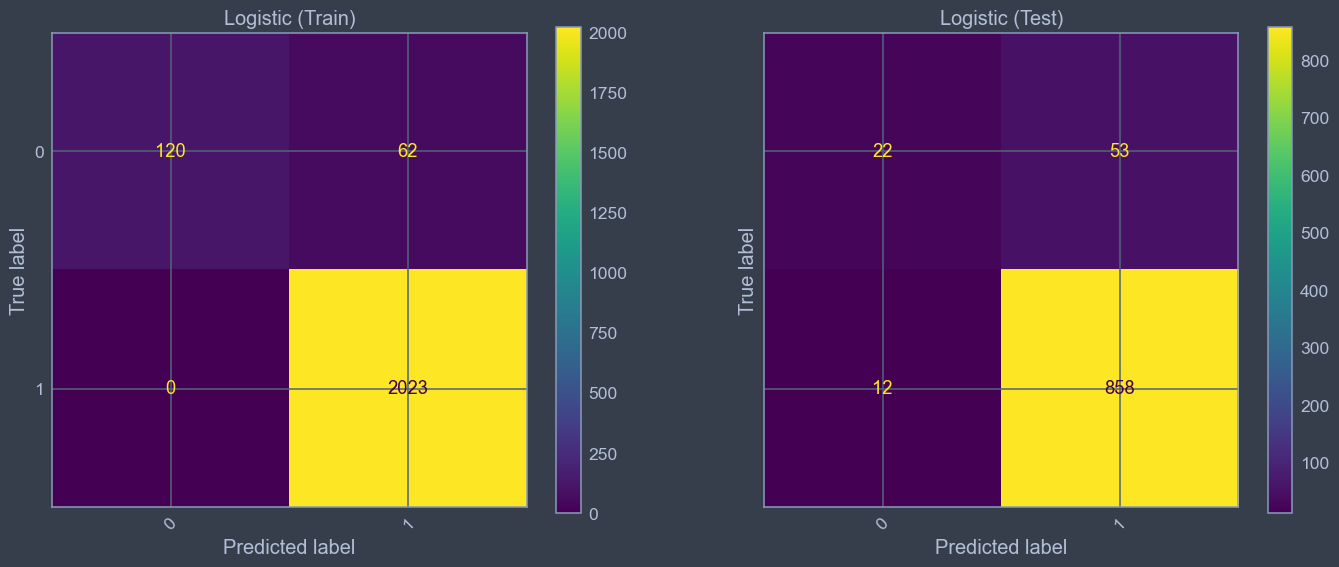

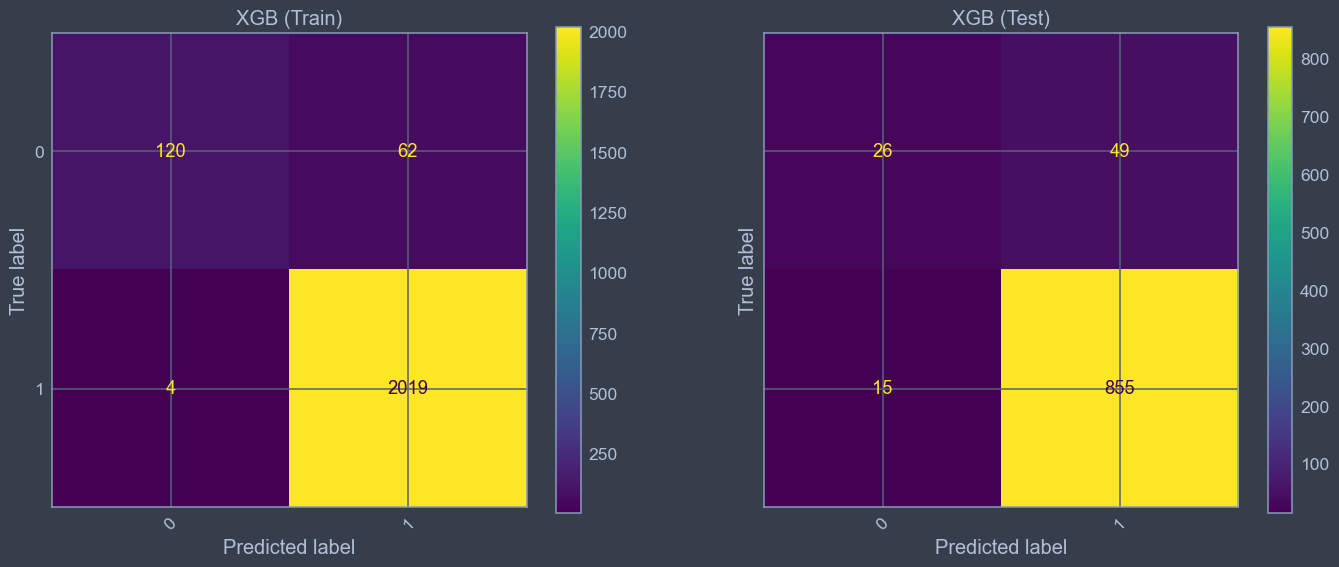

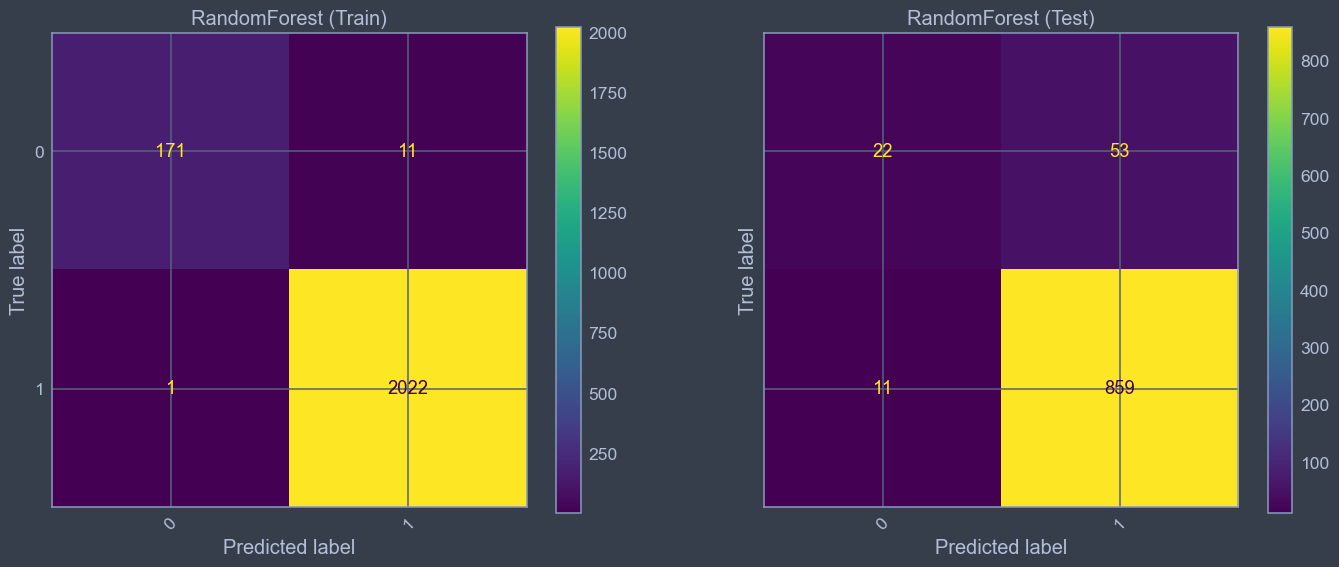

In [76]:
for name, result in models.items():
    f, axes = plt.subplots(1, 2, figsize=(15, 6), sharey='row')
    
    for i in range(2):
        if i == 0:
            cf_matrix = confusion_matrix(y_train, train_preds[name])
            title = name + ' (Train)'
        elif i == 1:
            cf_matrix = confusion_matrix(y_test, test_preds[name])
            title = name + ' (Test)'
        disp = ConfusionMatrixDisplay(cf_matrix)
        disp.plot(ax = axes[i], xticks_rotation=45)
        disp.ax_.set_title(title)

## Classification report

In [77]:
for name in models.keys():
    print(name, ' (Train)', '\n', classification_report(y_train, train_preds[name]), '\n')
    print(name, ' (Test)', '\n', classification_report(y_test, test_preds[name]))
    print('=' * 100, '\n')

Logistic  (Train) 
               precision    recall  f1-score   support

           0       1.00      0.66      0.79       182
           1       0.97      1.00      0.98      2023

    accuracy                           0.97      2205
   macro avg       0.99      0.83      0.89      2205
weighted avg       0.97      0.97      0.97      2205
 

Logistic  (Test) 
               precision    recall  f1-score   support

           0       0.65      0.29      0.40        75
           1       0.94      0.99      0.96       870

    accuracy                           0.93       945
   macro avg       0.79      0.64      0.68       945
weighted avg       0.92      0.93      0.92       945


XGB  (Train) 
               precision    recall  f1-score   support

           0       0.97      0.66      0.78       182
           1       0.97      1.00      0.98      2023

    accuracy                           0.97      2205
   macro avg       0.97      0.83      0.88      2205
weighted avg     

## Precision

In [78]:
precision_train_dict = {}
precision_test_dict = {}

for name in models.keys():
    precision_score_train = precision_score(y_train, train_preds[name])
    precision_score_test = precision_score(y_test, test_preds[name])  
    precision_train_dict[name] = precision_score_train
    precision_test_dict[name] = precision_score_test
    print(name, ' Precision score(Train)', precision_score_train, '\n', )
    print(name, ' Precision score(Test)', precision_score_test, '\n', )
    print('=' * 100, '\n')

Logistic  Precision score(Train) 0.9702637889688249 

Logistic  Precision score(Test) 0.9418221734357849 


XGB  Precision score(Train) 0.9702066314271984 

XGB  Precision score(Test) 0.9457964601769911 


RandomForest  Precision score(Train) 0.9945892769306444 

RandomForest  Precision score(Test) 0.9418859649122807 




## Recall

In [79]:
recall_train_dict = {}
recall_test_dict = {}

for name in models.keys():
    recall_score_train = recall_score(y_train, train_preds[name])
    recall_score_test = recall_score(y_test, test_preds[name])  
    recall_train_dict[name] = recall_score_train
    recall_test_dict[name] = recall_score_test
    print(name, ' Recall score(Train)', recall_score_train, '\n', )
    print(name, ' Recall score(Test)', recall_score_test, '\n', )
    print('=' * 100, '\n')

Logistic  Recall score(Train) 1.0 

Logistic  Recall score(Test) 0.9862068965517241 


XGB  Recall score(Train) 0.9980227385071676 

XGB  Recall score(Test) 0.9827586206896551 


RandomForest  Recall score(Train) 0.9995056846267919 

RandomForest  Recall score(Test) 0.9873563218390805 




## Accuracy

In [80]:
accuracy_train_dict = {}
accuracy_test_dict = {}

for name in models.keys():
    accuracy_score_train = accuracy_score(y_train, train_preds[name])
    accuracy_score_test = accuracy_score(y_test, test_preds[name])  
    accuracy_train_dict[name] =accuracy_score_train
    accuracy_test_dict[name] = accuracy_score_test
    print(name, ' accuracy score(Train)', accuracy_score_train, '\n', )
    print(name, ' accuracy score(Test)', accuracy_score_test, '\n', )
    print('=' * 100, '\n')

Logistic  accuracy score(Train) 0.9718820861678005 

Logistic  accuracy score(Test) 0.9312169312169312 


XGB  accuracy score(Train) 0.9700680272108844 

XGB  accuracy score(Test) 0.9322751322751323 


RandomForest  accuracy score(Train) 0.9945578231292517 

RandomForest  accuracy score(Test) 0.9322751322751323 




## Roc-auc

In [81]:
roc_auc_train_dict = {}
roc_auc_test_dict = {}

for name in models.keys():
    roc_auc_score_train = roc_auc_score(y_train, train_preds_proba[name][:, 1])
    roc_auc_score_test = roc_auc_score(y_test, test_preds_proba[name][:, 1])  
    roc_auc_train_dict[name] = roc_auc_score_train
    roc_auc_test_dict[name] = roc_auc_score_test
    print(name, ' Roc-auc score(Train)', roc_auc_score_train, '\n', )
    print(name, ' Roc-auc score(Test)', roc_auc_score_test, '\n', )
    print('=' * 100, '\n')

Logistic  Roc-auc score(Train) 0.9944022858011984 

Logistic  Roc-auc score(Test) 0.8713639846743295 


XGB  Roc-auc score(Train) 0.9839741326394812 

XGB  Roc-auc score(Test) 0.8720459770114942 


RandomForest  Roc-auc score(Train) 0.9997528423133959 

RandomForest  Roc-auc score(Test) 0.863793103448276 




# STEP 9: Displaying results

## Function for displaying

In [82]:
def show_matrix_results(first_bar, first_bar_label, second_bar, second_bar_label, labels, width, plot_title):
    fig, ax = plt.subplots(figsize=(14,7), facecolor=(.94, .94, .94))
    plt.tight_layout()
    
    y = np.arange(len(labels))  # Label locations
    ax.barh(y + width/2, first_bar, width, label=first_bar_label, color='cornflowerblue')
    ax.barh(y - width/2, second_bar, width, label=second_bar_label, color='lightgreen')
    
    title = plt.title(plot_title, pad=20, fontsize=18, color = 'black')
    
    rects = ax.patches
    for rect in rects:
        x_value = rect.get_width()
        y_value = rect.get_y() + rect.get_height() / 2
        space = 5
        ha = 'left'
        plt.annotate(
            np.round(x_value, 3),                      
            (x_value, y_value),         
            xytext=(space, 0),          
            textcoords='offset points',
            va='center',                
            ha=ha,)
    
    ax.set_yticklabels(labels, color = 'black')
    ax.legend(loc = 'best')
    
    plt.yticks(np.arange(min(y), max(y)+1, 1.0))
    
 

## Accuracy

D:\Anaconda\envs\KV_DW_JL_5\lib\site-packages\ipykernel_launcher.py:25: UserWarning:

FixedFormatter should only be used together with FixedLocator



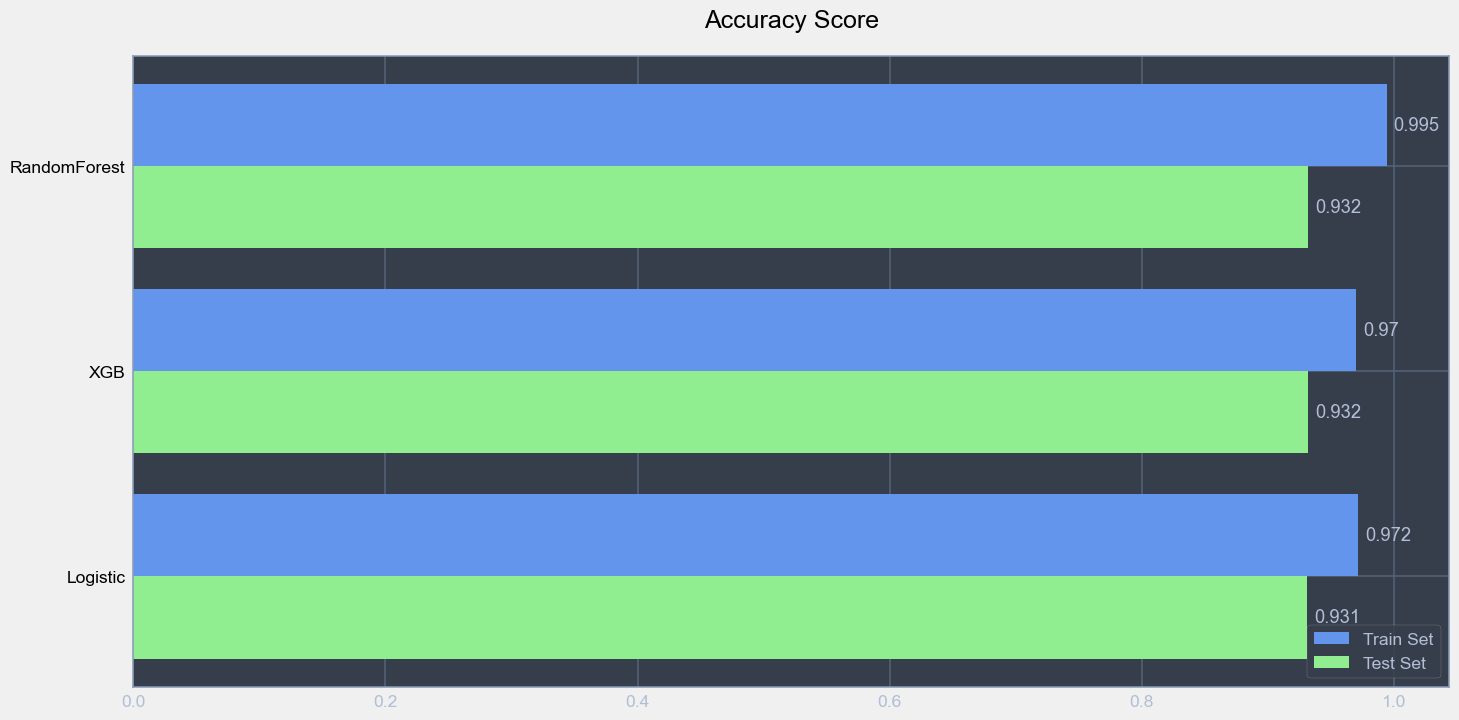

In [83]:
accuracy_test_dict = dict(sorted(accuracy_test_dict.items(), key = lambda item: item[1]))
sorted_keys = accuracy_test_dict.keys()
accuracy_train_dict = {key: accuracy_train_dict[key] for key in sorted_keys}

first_bar = accuracy_train_dict.values()
first_bar_label = 'Train Set'
second_bar = accuracy_test_dict.values()
second_bar_label = 'Test Set'
labels = sorted_keys
width = 0.4
plot_title = 'Accuracy Score'


show_matrix_results(first_bar, first_bar_label, second_bar, second_bar_label, labels, width, plot_title) 

## Precision

D:\Anaconda\envs\KV_DW_JL_5\lib\site-packages\ipykernel_launcher.py:25: UserWarning:

FixedFormatter should only be used together with FixedLocator



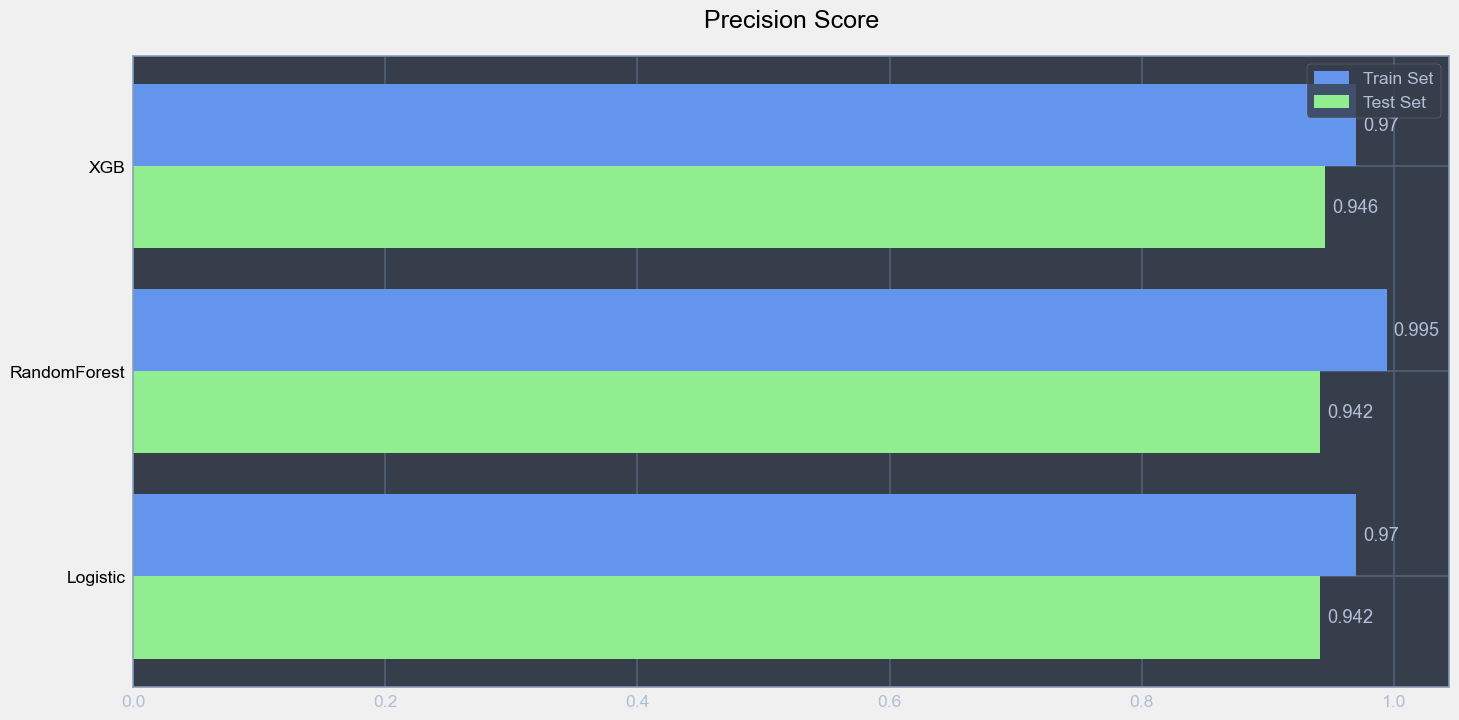

In [84]:
precision_test_dict = dict(sorted(precision_test_dict.items(), key = lambda item: item[1]))
sorted_keys = precision_test_dict.keys()
precision_train_dict = {key: precision_train_dict[key] for key in sorted_keys}

first_bar = precision_train_dict.values()
first_bar_label = 'Train Set'
second_bar = precision_test_dict.values()
second_bar_label = 'Test Set'
labels = sorted_keys
width = 0.4
plot_title = 'Precision Score'


show_matrix_results(first_bar, first_bar_label, second_bar, second_bar_label, labels, width, plot_title) 

## Recall

D:\Anaconda\envs\KV_DW_JL_5\lib\site-packages\ipykernel_launcher.py:25: UserWarning:

FixedFormatter should only be used together with FixedLocator



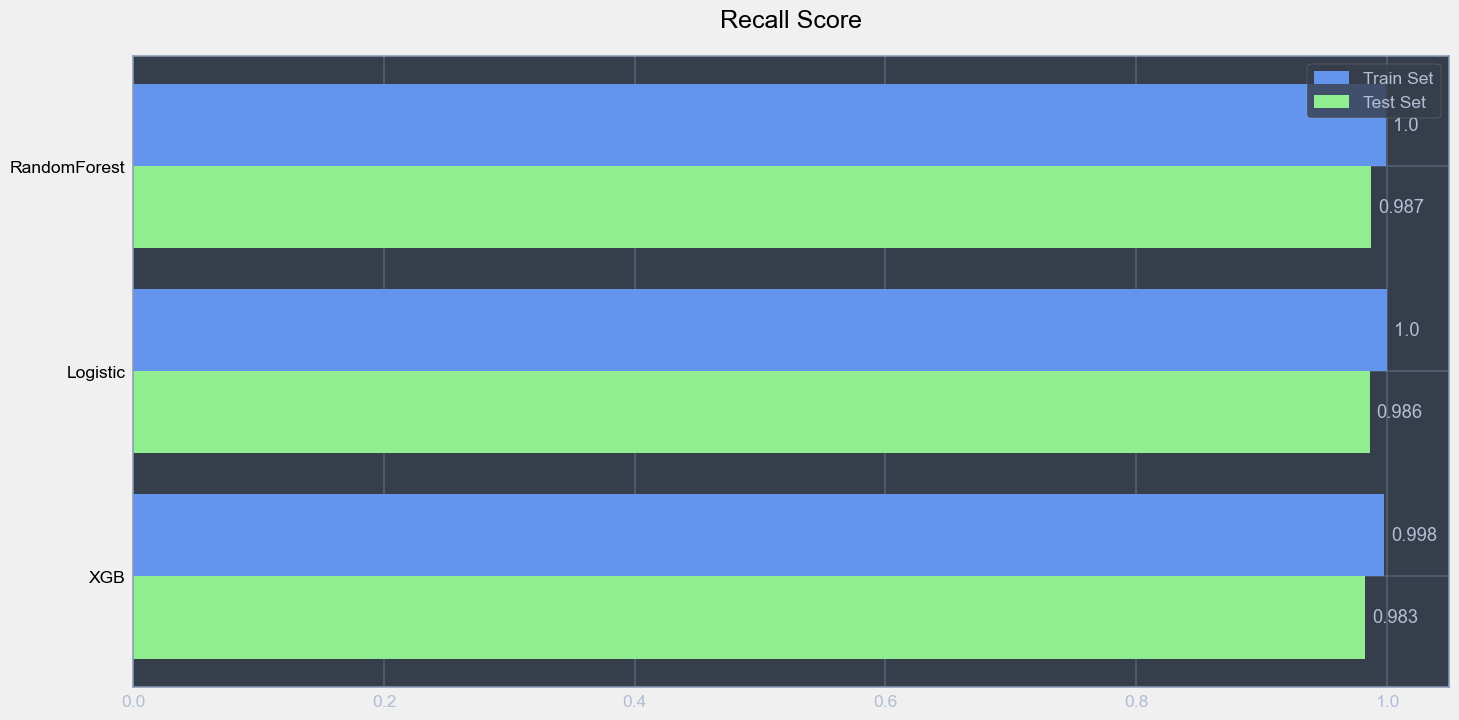

In [85]:
recall_test_dict = dict(sorted(recall_test_dict.items(), key = lambda item: item[1]))
sorted_keys = recall_test_dict.keys()
recall_train_dict = {key: recall_train_dict[key] for key in sorted_keys}

first_bar = recall_train_dict.values()
first_bar_label = 'Train Set'
second_bar = recall_test_dict.values()
second_bar_label = 'Test Set'
labels = sorted_keys
width = 0.4
plot_title = 'Recall Score'


show_matrix_results(first_bar, first_bar_label, second_bar, second_bar_label, labels, width, plot_title) 

## Roc-auc

D:\Anaconda\envs\KV_DW_JL_5\lib\site-packages\ipykernel_launcher.py:25: UserWarning:

FixedFormatter should only be used together with FixedLocator



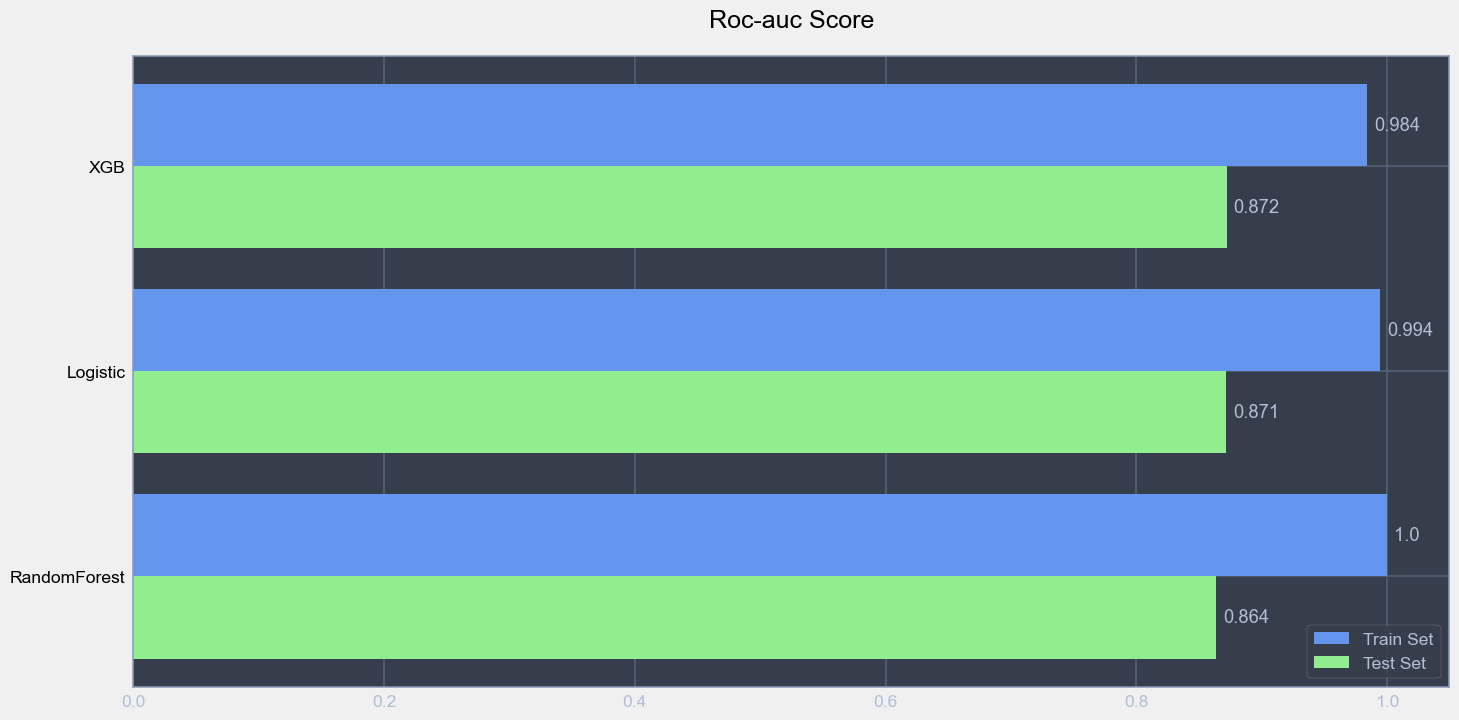

In [86]:
roc_auc_test_dict = dict(sorted(roc_auc_test_dict.items(), key = lambda item: item[1]))
sorted_keys = roc_auc_test_dict.keys()
roc_auc_train_dict = {key: roc_auc_train_dict[key] for key in sorted_keys}

first_bar = roc_auc_train_dict.values()
first_bar_label = 'Train Set'
second_bar = roc_auc_test_dict.values()
second_bar_label = 'Test Set'
labels = sorted_keys
width = 0.4
plot_title = 'Roc-auc Score'


show_matrix_results(first_bar, first_bar_label, second_bar, second_bar_label, labels, width, plot_title) 

    After displaying all results, We can conclude that according to the matrixes we used (Precistion, Recall, Accuracy and Roc_auc), and the cross-validation The best choice here will be XGB, because it gives both best and stabel performances 

# STEP 10: Saving everything

## Saving models

In [91]:
dump(XGB, open('XGB.pkl', 'wb'))
dump(Logistic, open('Logistic.pkl', 'wb'))
dump(RandomForest, open('RandomForest.pkl', 'wb'))

# STEP 11: Conclusion

##  Data Analysis

    After completing the data analysis step, we found several insights. 

        1. We got the not balanced dataset

        2. All reviews in the dataset were done in 2018 year

        3. More than 90% of all reviews were written in July

        4. 75% of all reviews were made on 28, 29 and 30th day which is the end of the month, but there were a really little amount of reviews on the 31st days of each month. We assume that is just because not every month has a 31st day in it 

        5. The majority of all reviews were made at the beginning (Monday) and the end (Saturday, Sunday) of the week.

        6. more than 70% of the dataset consists of 5 star ratings which means that the majority of reviews were on the positive side.

        7. Black Dot is the most popular variation among all others

        8. The Black Dot and Charcoal variations are receiving higher ratings compared to others

        9. Black Dot variation also has the biggest amount of low ratings (1, 2, 3 stars).

        10.Black Dot, Charcoal Fabric and Configuration: Fire TV Stick are three variations with the biggest amount of positive feedback.

        11.Black Dot, Black and Black Spot are getting more negative feedback compared to others

        12.If the product has rating 1 or 2 it will be the negative feedback, on the other hand, if the rating is equal or more than 3 stars, it will probably be the positive feedback

        13.There are no null values in the dataset.

        14.Love, Thing, Music are one of the frequently used words in the positive feedbacks

        15.Siri, product, terrible are one of the frequently used words in the negative feedbacks

        

   ## Training & Evaluating ANN

   

     > Because we are working with NLP, we need to encode Variations and Verified_reviews

     > We have tested 8 popular models with the same data and same preprocessing steps to then compare them and choose only fixed amounts to tune the hyperparameters. 

     > After testing 8 models, we chose only 3 best models according to the accuracy metrics 

     > Then, we used cross-validation and started to fine-tune hyperparameters to boost the performance 

     > lastly, We have evaluated the models we built using several metrics including: 

         1. F1 score

         2. Roc-auc 

         3. Confusion Matrix 

         4. Precision

         5. Recall 

         6. Accuracy

         

    By analyzing all metrics we can tell that: 

        1.It seems that the overall performance of the models is higher for the not-balanced dataset

        2.We need to tune hyperparameters for the models in this project, because after finetuning of hyperparameters by RandomSearchCV the overall performance and accuracy has raised compared to the models without tuned hyperparameters

        3.We assume that XGBoostClassifier is the best choice here, because it shows both high and stable performance regarding Accuracy, Recall, Precision and ROC-AUC.

        

       

   # THANKS!!! :)